In [1]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

# Memoria FAA P2 
### Autores: Sergio Torrijos, Sergio Salcedo y Gloria del Valle

#### Consideraciones Previas: 
En la memoria aparece un botón en la parte superior para poder visualizar u ocultar el código encargado de reproducir cada uno de los ejemplos y gráficas.

In [2]:
from Datos import Datos
import EstrategiaParticionado
import Clasificador
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from IPython.display import HTML
from plotModel import plotModel
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
seed = np.random.seed()

# Apartado 1: KNN (Implementación propia y Scikit-Learn)

Antes de comenzar a comentar los resultados de la clasificación de varios datasets con KNN, vamos a introducir características generales que afectan a todos los casos de una forma u otra, en función de la distribución de los datos.

Es primer lugar, comentar que es muy importante la correcta elección de un k para minimizar el error de clasificación. Esto va a depender mucho en función de la distribución de los puntos en el espacio del dataset.

Con k=1, estamos eligiendo el vecino más próximo al punto que queremos clasificar, esto es muy arriesgado y por lo general suele funcionar mal ya que por ejemplo entre una nube de puntos de clase 1 puede que exista algún punto de clase 2(que puede ser ruido) y si tenemos la mala suerte de que el vecino más cercano es la clase del ruido, estamos realizando una clasificación incorrecta. Este mismo ejemplo podría solucionarse con k=3 ya que si por ejemplo en la nube de puntos anterior sólo hay 1 punto de clase 2, los k mayoritarios serían de clase 1. 

Pero esto es un caso muy particular, puede que existan varios puntos de clase 2 que aporten ruido y esto daría lugar al mismo problema. Es por ello que es muy importante estudiar la distribución de los puntos y elegir un k adecuado. 

Otra anotación importante, es que hay que elegir k impar, ya que si el k es par, puede haber empate y en caso de empate la elección de la clase es aleatoria. 

Continuando con la elección del k adecuado, también es malo elegir un valor demasiado alto, ya que al estar escogiendo los k más similares, un k alto puede ser innecesario o impreciso, ya que podríamos repetir vecinos muy similares entre sí.

Por otra parte, tenemos que destacar el parámetro weights que se le pasa al clasificador KNN. Este parámetro es una forma de indicar al clasificador como evaluar las distancias de los vecinos más cercanos.

Si **weights='uniform'**, quiere decir que knn evaluará todas las dictancias de todos los vecinos por igual sin hacer discriminaciones. En cambio si  **weights='distance'**, los vecinos son evaluados por la inversa de su distancia, de esta forma los vecinos que se sitúen más cerca de un ejemplo, tendrán mejor puntuación que otros vecinos más lejanos.

Con esto conseguimos que por ejemplo en el caso de que encontrásemos 10 elementos de clase 2. Y 7 elementos de clase 1, si los de clase 1 están más cercanos les dará preferencia, clasificando el resultado como clase 1

Más tarde comentaremos la comparativa con los datos sin normalizar y escogiendo el estándar para el cálculo de la distancia.

### K=1, 3, 5, 11, 21 y 51

In [13]:
d_ex1 = Datos('wdbc.data')
d_ex1_norm = Datos('wdbc.data', normalizar=True)
d_ex2 = Datos('online_shoppers.data')
d_ex2_norm = Datos('online_shoppers.data', normalizar=True)
d_ex3 = Datos('example1.data')
d_ex4 = Datos('example2.data')
d_ex5 = Datos('example3.data')
d_ex6 = Datos('example4.data')
d_ex6_norm = Datos('example4.data', normalizar=True)

### Pruebas para diferentes k con wdbc.data, weights=distance, validación cruzada y datos normalizados

In [4]:
k=1
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error1 = c.validacion(estrategia, d_ex1_norm, c, seed)

In [5]:
k=3
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error3 = c.validacion(estrategia, d_ex1_norm, c, seed)

In [6]:
k=5
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error5 = c.validacion(estrategia, d_ex1_norm, c, seed)

In [7]:
k=11
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error11 = c.validacion(estrategia, d_ex1_norm, c, seed)

In [8]:
k=21
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error21 = c.validacion(estrategia, d_ex1_norm, c, seed)

In [9]:
k=55
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error55 = c.validacion(estrategia, d_ex1_norm, c, seed)

In [10]:
X = d_ex1.datos[:,:-1]
y = d_ex1.datos[:,-1]
scaler = preprocessing.StandardScaler().fit(X)
X_scale = scaler.transform(X) 
vecinos = [1,3,5,11,21,55]

In [7]:
truncate = lambda num: round(num, 3)

In [4]:
def trainAndPlotKNN(errors, stds, neighbours, title, X, y, weights_param='distance'):
    
    errors_sk = []
    stds_sk = []
    html_output = """<table style="width:100%">
    <caption>""" + title + """</caption>
     <tr>
    <th>K</th>
    <th>Nuestro</th>
    <th>Scikit</th>
  </tr>
    """
    
    
    for index, neighbour in enumerate(neighbours):
        clasificador = KNeighborsClassifier(n_neighbors=neighbour, weights=weights_param)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed, stratify=y)
        clasificador.fit(X_train, y_train)
        err = 1 - clasificador.score(X_test, y_test)
        errors_sk.append(err)
        stds_sk.append(np.std(err))
        
        html_output += "<tr><td>{}</td><td>{}+-{}</td><td>{}+-{}</td></tr>".format(neighbour, truncate(np.mean(errors[index])), truncate(stds[index]), truncate(errors_sk[index]), truncate(stds_sk[index]))
        
    html_output += "</table>"
    
    
    display(HTML(html_output))
     
    errors = stds = []    
    
    

In [5]:
def plotKNN(errors, title, weights_param='distance'):
    errors_sk = []
    stds_sk = []
    html_output = """<table style="width:100%">
    <caption>""" + title + """</caption>
     <tr>
    <th>K</th>
    <th>Nuestro</th>
  </tr>
    """
    for error, neighbour in errors:
        html_output += "<tr><td>{}</td><td>{}+-{}</td></tr>".format(neighbour, truncate(np.mean(error)), truncate(np.std(error)))
    html_output += "</table>"
    display(HTML(html_output))

In [6]:
def trainAndPlotKNNCross(errors, stds, neighbours, X, y, weights_param='distance', dataset_name='wdbc.data'):
    
    errors_sk = []
    stds_sk = []
    
    title_str = "Error y desviacion tipica con KNN(Validacion Cruzada) para " + dataset_name + "(weights = {})".format('distance' if weights_param == 'distance' else 'uniform')
    
    html_output = """<table style="width:100%">
    <caption>""" + title_str + """</caption>
     <tr>
    <th>K</th>
    <th>Nuestro</th>
    <th>Scikit</th>
  </tr>
    """
    
    
    for index, neighbour in enumerate(neighbours):
        clasificador = KNeighborsClassifier(n_neighbors=neighbour, weights=weights_param)
        err = 1 - cross_val_score(clasificador, X, y, cv=5)
        errors_sk.append(err)
        stds_sk.append(np.std(err))
        
        html_output += "<tr><td>{}</td><td>{}+-{}</td><td>{}+-{}</td></tr>".format(neighbour, truncate(np.mean(errors[index])), truncate(stds[index]), truncate(np.mean(err)), truncate(np.std(err)))
        
    html_output += "</table>"
    
    
    display(HTML(html_output))
     
    errors = stds = []    

In [15]:
stds = [np.std(error1), np.std(error3), np.std(error5), np.std(error11), np.std(error21), np.std(error55)]
trainAndPlotKNNCross([error1, error3, error5, error11, error21, error55], stds, [1, 3, 5, 11, 21, 55], X_scale, y)

K,Nuestro,Scikit
1,0.051+-0.014,0.049+-0.016
3,0.028+-0.024,0.042+-0.019
5,0.032+-0.012,0.035+-0.01
11,0.037+-0.023,0.039+-0.018
21,0.044+-0.018,0.046+-0.014
55,0.051+-0.017,0.046+-0.015


###### Comentarios de los resultados
Los resultados presentados muestran la clasificación de vecinos próximos para cada k pedido del fichero wdbc.data, en el cual cada atributo es continuo, realizando la inversa de la distancia, normalizando los datos y realizando una validación cruzada de 5 k-folds. Mostramos la comparativa en las mismas condiciones con Scikit y podemos ver que los resultados son muy similares entre sí entre ambas implementaciones.

Al escoger weights=distance, estamos haciendo que cada uno de los puntos tengan un peso específico, lo que resalta la diferencia entre puntos que están más cerca de otros. Por tanto, el peso entre vecinos más cercanos es mayor que los que se encuentran más lejanos. Esto es importante para valorar que los vecinos más cercanos pueden dar más confianza en la indicación de la clase. Esta variación de KNN puede ser interesante dependiendo del dataset y puede ser útil para aumentar la confianza de la predicción.

También podemos comprobar que la elección del k es relevante. En vecinos próximos tenemos el objetivo de encontrar los k más similares, por tanto una elección de un k muy alto puede ser innecesaria o imprecisa, ya que con un número más bajo podemos encontrar predicciones que se parezcan más a la clasificación que queramos obtener. Un k muy bajo también es impreciso, ya que, por ejemplo, en el caso de k=1, sólo nos estamos centrando en un vecino y esto no maneja un rango de valores suficiente como para dar una predicción razonada. Por tanto, los valores más asequibles podrían ser k=5, k=11, o incluso, en nuestro caso, al tener 569 atributos, k=3 puede ser también un valor interesante.




### Pruebas para diferentes k con online_shoppers.data, weights=distance, validación simple y datos normalizados

In [16]:
k=1
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error1 = c.validacion(estrategia, d_ex2_norm, c, seed)

In [17]:
k=3
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error3 = c.validacion(estrategia, d_ex2_norm, c, seed)

In [18]:
k=5
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error5 = c.validacion(estrategia, d_ex2_norm, c, seed)

In [19]:
k=11
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error11 = c.validacion(estrategia, d_ex2_norm, c, seed)

In [20]:
k=21
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error21 = c.validacion(estrategia, d_ex2_norm, c, seed)

In [21]:
k=55
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error55 = c.validacion(estrategia, d_ex2_norm, c, seed)

In [22]:
X = d_ex2.datos[:,:-1]
y = d_ex2.datos[:,-1]
scaler = preprocessing.StandardScaler().fit(X)
X_scale = scaler.transform(X)

vecinos = [1,3,5,11,21,55]


En este caso normalizar los datos puede resultar interesante debido a que tenemos un gran número de atributos, cada uno ponderados de manera diferente (por ejemplo columna meses, entre otros), sumado a una gran mezcla de atributos nominales y continuos. Por ello reducir la distancia entre ellos (media 0 y varianza 1) nos ayudará a encontrar una buena clasificación evitando ponderar unas columnas más que otras.

Los casos explicados previamente en cuanto a la elección del k y del cálculo de la distancia, son igualmente relevantes.

Como podeemos ver, los datos salen muy parecidos a Scikit, e incluso mejores, principalmente por la ponderación que hemos hecho de columnas especiales discretas, ponderando las distancias de los meses de forma congruente, entre otros atributos. Estas distancias son ignoradas por scikit resultando un error mayor en estos casos.


In [23]:
stds = [np.std(error1), np.std(error3), np.std(error5), np.std(error11), np.std(error21), np.std(error55)]
trainAndPlotKNN([error1, error3, error5, error11, error21, error55], stds, [1, 3, 5, 11, 21, 55], "Error y desviacion tipica con KNN(Validacion Simple) para online_shoppers.data (weights=distance)", X_scale, y)

K,Nuestro,Scikit
1,0.162+-0.0,0.161+-0.0
3,0.134+-0.0,0.132+-0.0
5,0.125+-0.0,0.125+-0.0
11,0.128+-0.0,0.122+-0.0
21,0.117+-0.0,0.124+-0.0
55,0.127+-0.0,0.127+-0.0


### Pruebas para diferentes k con wdbc.data, weights=uniform, validación cruzada y datos normalizados

In [24]:
k=1
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error1 = c.validacion(estrategia, d_ex1_norm, c, seed)

In [25]:
k=3
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error3 = c.validacion(estrategia, d_ex1_norm, c, seed)

In [26]:
k=5
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error5 = c.validacion(estrategia, d_ex1_norm, c, seed)

In [27]:
k=11
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error11 = c.validacion(estrategia, d_ex1_norm, c, seed)

In [28]:
k=21
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error21 = c.validacion(estrategia, d_ex1_norm, c, seed)

In [29]:
k=55
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error55 = c.validacion(estrategia, d_ex1_norm, c, seed)

In [30]:
X = d_ex1.datos[:,:-1]
y = d_ex1.datos[:,-1]
vecinos = [1,3,5,11,21,55]
scaler = preprocessing.StandardScaler().fit(X)
X_scale = scaler.transform(X)

In [31]:
stds = [np.std(error1), np.std(error3), np.std(error5), np.std(error11), np.std(error21), np.std(error55)]
trainAndPlotKNNCross([error1, error3, error5, error11, error21, error55], stds, [1, 3, 5, 11, 21, 55], X_scale, y, weights_param='uniform')

K,Nuestro,Scikit
1,0.035+-0.011,0.049+-0.016
3,0.035+-0.017,0.042+-0.019
5,0.033+-0.016,0.035+-0.01
11,0.033+-0.012,0.039+-0.018
21,0.046+-0.017,0.047+-0.016
55,0.053+-0.017,0.051+-0.018


Los resultados presentados muestran la clasificación de vecinos próximos para cada k pedido del fichero wdbc.data, en el cual cada atributo es continuo, realizando el estandar de la distancia (distancia euclídea simple), normalizando los datos y realizando una validación cruzada de 5 k-folds. Mostramos la comparativa en las mismas condiciones con Scikit y podemos ver que los resultados son muy similares entre sí entre ambas implementaciones.

Aparte de lo que hemos comentado previamente de la elección del k, es preciso valorar la elección de weights=uniform. En el caso de este fichero, no es una elección determinante en la obtención del error, y obtenemos unos datos muy similares, pero es verdad que parece que weights=distance puede ser una opción interesante, remitiéndonos a la justificación previamente expuesta.

Podemos ver que los errores salen muy parecidos a los de Scikit ya que los atributos no están mezclados

### Pruebas para diferentes k con online_shoppers.data, weights=uniform, validación simple y datos normalizados

In [32]:
k=1
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error1 = c.validacion(estrategia, d_ex2_norm, c, seed)

In [33]:
k=3
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error3 = c.validacion(estrategia, d_ex2_norm, c, seed)

In [34]:
k=5
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error5 = c.validacion(estrategia, d_ex2_norm, c, seed)

In [35]:
k=11
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error11 = c.validacion(estrategia, d_ex2_norm, c, seed)

In [36]:
k=21
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error21 = c.validacion(estrategia, d_ex2_norm, c, seed)

In [37]:
k=55
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error55 = c.validacion(estrategia, d_ex2_norm, c, seed)

In [38]:
X = d_ex2.datos[:,:-1]
y = d_ex2.datos[:,-1]
vecinos = [1,3,5,11,21,55]
scaler = preprocessing.StandardScaler().fit(X)
X_scale = scaler.transform(X)

En el caso de la elección de la distancia es significativo destacar que no hay diferencia entre utilizar weights=distance y weights=uniform porque los datos están relativamente igual de dispersos. Podemos asegurar que en este caso normalizar los datos es igualmente importante y que los datos de los errores obtenidos siguen en concordancia con los de Scikit, salvando las distancias como hemos comentado anteriormente.

Un dato relevante que hemos visto, no sólo en esta tabla, es que utilizando partición simple no podemos pasarle la semilla a Scikit y por lo tanto, podemos apreciar esa diferencia en el error entre el nuestro y scikit debido a que nosotros se la pasamos fija y en scikit cada vez que la invocamos genera una semilla aleatoria, que no tiene por que partir la tabla en igualdad de condiciones.

In [39]:
stds = [np.std(error1), np.std(error3), np.std(error5), np.std(error11), np.std(error21), np.std(error55)]
trainAndPlotKNN([error1, error3, error5, error11, error21, error55], stds, [1, 3, 5, 11, 21, 55], "Error y desviacion tipica con KNN(Validacion Simple) para online_shoppers.data (weights=uniform)", X_scale, y, weights_param='uniform')

K,Nuestro,Scikit
1,0.15+-0.0,0.159+-0.0
3,0.13+-0.0,0.137+-0.0
5,0.125+-0.0,0.127+-0.0
11,0.123+-0.0,0.119+-0.0
21,0.13+-0.0,0.123+-0.0
55,0.127+-0.0,0.128+-0.0


### Pruebas para diferentes k con online_shoppers.data, weights=distance, validación simple y datos no normalizados

In [40]:
k=1
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error1 = c.validacion(estrategia, d_ex2, c, seed)

In [41]:
k=3
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error3 = c.validacion(estrategia, d_ex2, c, seed)

In [42]:
k=5
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error5 = c.validacion(estrategia, d_ex2, c, seed)

In [43]:
k=11
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error11 = c.validacion(estrategia, d_ex2, c, seed)

In [44]:
k=21
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error21 = c.validacion(estrategia, d_ex2, c, seed)

In [45]:
k=55
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error55 = c.validacion(estrategia, d_ex2, c, seed)

In [46]:
X = d_ex2.datos[:,:-1]
y = d_ex2.datos[:,-1]

vecinos = [1,3,5,11,21,55]


En este caso podemos ver que el error obtenido es mayor. Esto es debido a lo que comentábamos previamente de la importancia de normalizar los datos en este caso. Vemos también que el error es muy parecido al de Scikit porque al no haber normalizado los datos, aún jugando con la ventaja de clasificar la columna meses diferente, ésta tiene valores entre 1 y 12, cuando una columna normal tiene valores entre 1 y 2. Entonces, pese a todo el esfuerzo, estaría clasificándolo incorrectamente al igual que Scikit.

In [47]:
stds = [np.std(error1), np.std(error3), np.std(error5), np.std(error11), np.std(error21), np.std(error55)]
trainAndPlotKNN([error1, error3, error5, error11, error21, error55], stds, [1, 3, 5, 11, 21, 55], "Error y desviacion tipica con KNN(Validacion Simple) para online_shoppers.data (weights=distance)", X, y)

K,Nuestro,Scikit
1,0.175+-0.0,0.176+-0.0
3,0.151+-0.0,0.15+-0.0
5,0.145+-0.0,0.145+-0.0
11,0.137+-0.0,0.137+-0.0
21,0.144+-0.0,0.136+-0.0
55,0.143+-0.0,0.146+-0.0


### Pruebas para diferentes k con wdbc.data, weights=distance, validación cruzada y datos no normalizados

In [48]:
k=1
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error1 = c.validacion(estrategia, d_ex1, c, seed)

In [49]:
k=3
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error3 = c.validacion(estrategia, d_ex1, c, seed)

In [50]:
k=5
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error5 = c.validacion(estrategia, d_ex1, c, seed)

In [51]:
k=11
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error11 = c.validacion(estrategia, d_ex1, c, seed)

In [52]:
k=21
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error21 = c.validacion(estrategia, d_ex1, c, seed)

In [53]:
k=55
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='distance')
error55 = c.validacion(estrategia, d_ex1, c, seed)

In [54]:
X = d_ex1.datos[:,:-1]
y = d_ex1.datos[:,-1]

vecinos = [1,3,5,11,21,55]

In [55]:
stds = [np.std(error1), np.std(error3), np.std(error5), np.std(error11), np.std(error21), np.std(error55)]
trainAndPlotKNNCross([error1, error3, error5, error11, error21, error55], stds, [1, 3, 5, 11, 21, 55], X, y, weights_param='distance', dataset_name='wdbc')

K,Nuestro,Scikit
1,0.084+-0.023,0.095+-0.023
3,0.067+-0.019,0.075+-0.025
5,0.068+-0.028,0.07+-0.018
11,0.069+-0.015,0.072+-0.03
21,0.07+-0.015,0.075+-0.032
55,0.086+-0.014,0.079+-0.034


Los resultados presentados muestran la clasificación de vecinos próximos para cada k pedido del fichero wdbc.data, en el cual cada atributo es continuo, realizando la inversa de la distancia, sin normalizar los datos y realizando una validación cruzada de 5 k-folds. Mostramos la comparativa en las mismas condiciones con Scikit y podemos ver que los resultados son muy similares entre sí entre ambas implementaciones.

Es preciso destacar que, respecto de las anteriores pruebas normalizando los datos previamente, el error es un poquito más alto. La elección de normalizar es un caso interesante porque nos puede servir para separar los datos y calcular mejor la distancia de unos con otros. En este caso tampoco es muy significativo, pero en casos concretos dependiendo del dataset, nos puede servir para solucionar la posición de los vecinos entre sí, ya que se pueden dar casos de datasets en los que los vecinos estén mucho más alineados, por consiguiente, esto puede ser un problema a la hora de clasificar los datos.

### Pruebas para diferentes k con wdbc.data, weights=uniform, validación cruzada y datos no normalizados

In [56]:
k=1
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error1 = c.validacion(estrategia, d_ex1, c, seed)

In [57]:
k=3
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error3 = c.validacion(estrategia, d_ex1, c, seed)

In [58]:
k=5
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error5 = c.validacion(estrategia, d_ex1, c, seed)

In [59]:
k=11
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error11 = c.validacion(estrategia, d_ex1, c, seed)

In [60]:
k=21
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error21 = c.validacion(estrategia, d_ex1, c, seed)

In [61]:
k=55
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error55 = c.validacion(estrategia, d_ex1, c, seed)

In [62]:
X = d_ex1.datos[:,:-1]
y = d_ex1.datos[:,-1]

vecinos = [1,3,5,11,21,55]

In [63]:
stds = [np.std(error1), np.std(error3), np.std(error5), np.std(error11), np.std(error21), np.std(error55)]
trainAndPlotKNNCross([error1, error3, error5, error11, error21, error55], stds, [1, 3, 5, 11, 21, 55], X, y, weights_param='uniform', dataset_name='wdbc')

K,Nuestro,Scikit
1,0.079+-0.008,0.095+-0.023
3,0.074+-0.033,0.081+-0.024
5,0.076+-0.034,0.072+-0.021
11,0.072+-0.032,0.07+-0.027
21,0.072+-0.019,0.07+-0.034
55,0.088+-0.012,0.084+-0.025


##### Comentarios de los resultados
Finalmente, basándonos en las anteriores explicaciones, podemos comprobar que en todos los casos sigue siendo significativa la elección del k, se comprueba la diferencia entre normalizar o no (aunque en wdbc.data esto puede no ser tan interesante) y que los resultados obtenidos mediante nuestro algoritmo y el de Scikit son realmente parecidos, por lo que podemos concluir con que la implementación es robusta.

### Pruebas para diferentes k con online_shoppers.data, weights=uniform, validación simple y datos no normalizados

In [64]:
k=1
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error1 = c.validacion(estrategia, d_ex2, c, seed)

In [65]:
k=3
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error3 = c.validacion(estrategia, d_ex2, c, seed)

In [66]:
k=5
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error5 = c.validacion(estrategia, d_ex2, c, seed)

In [67]:
k=11
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error11 = c.validacion(estrategia, d_ex2, c, seed)

In [68]:
k=21
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error21 = c.validacion(estrategia, d_ex2, c, seed)

In [69]:
k=55
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform')
error55 = c.validacion(estrategia, d_ex2, c, seed)

In [70]:
X = d_ex2.datos[:,:-1]
y = d_ex2.datos[:,-1]

vecinos = [1,3,5,11,21,55]

Aquí podemos ver que la elección de la distancia no varía demasiado, remitiéndonos a que los datos están prácticamente igual de dispersos.
Asimismo, seguimos viendo la importancia de normalizar los datos en cuanto a este dataset.

In [71]:
stds = [np.std(error1), np.std(error3), np.std(error5), np.std(error11), np.std(error21), np.std(error55)]
trainAndPlotKNN([error1, error3, error5, error11, error21, error55], stds, [1, 3, 5, 11, 21, 55], "Error y desviacion tipica con KNN(Validacion Simple) para online_shopers.data (weights=uniform)", X, y, weights_param='uniform')

K,Nuestro,Scikit
1,0.172+-0.0,0.171+-0.0
3,0.151+-0.0,0.142+-0.0
5,0.141+-0.0,0.141+-0.0
11,0.14+-0.0,0.134+-0.0
21,0.139+-0.0,0.138+-0.0
55,0.154+-0.0,0.15+-0.0


A modo de conclusión, en el caso de knn resulta muy útil estandarizar los datos para ponderar por igual las distancias entre todos los elementos de todas las columnas, y no priorizar unas columnas frente a otras, como por ejemplo una columna que tenga valores entre 10 y 20 y otra entre 100 y 200.

Los casos explicados previamente en cuanto a la elección del k y del cálculo de la distancia, son igualmente relevantes. En el caso de la elección de la distancia es significativo destacar que no hay diferencia entre utilizar weights=distance y weights=uniform porque los datos están relativamente igual de dispersos.

### Pruebas example1.data, example2.data, example3.data y example4.data con plotModel.py

##### example1.data

K,Nuestro
1,0.168+-0.033
3,0.128+-0.005
5,0.142+-0.042
11,0.155+-0.045
21,0.145+-0.027
55,0.17+-0.032


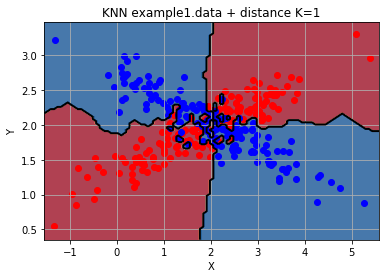

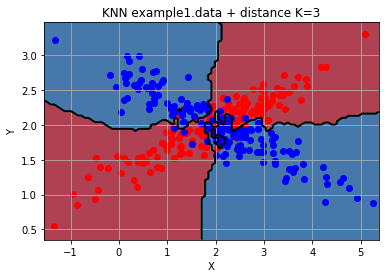

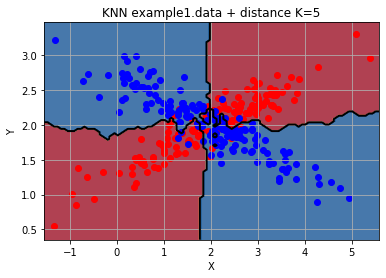

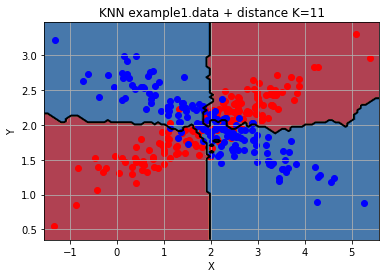

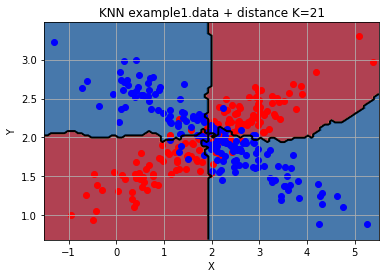

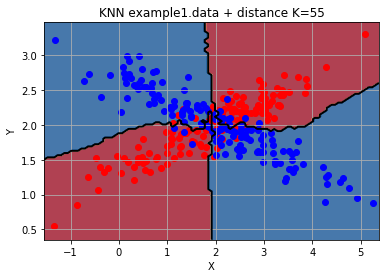

<Figure size 432x288 with 0 Axes>

In [72]:
k_vecinos=[1,3,5,11,21,55]
errores = []

for k in k_vecinos:
    estrategia = EstrategiaParticionado.ValidacionCruzada(5)
    c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform', normalizar = False)
    error = c.validacion(estrategia, d_ex3, c, seed)
    errores.append((error, k))

    estrategia.creaParticiones(d_ex3.datos, seed=seed)
    train = estrategia.particiones[-1].indicesTrain
    test = estrategia.particiones[-1].indicesTest

    datostrain= d_ex3.extraeDatos(train)
    datostest= d_ex3.extraeDatos(test)

    c.entrenamiento(datostrain, d_ex3.nominalAtributos, d_ex3.diccionarios)

    ii = estrategia.particiones[-1].indicesTrain

    plotModel(d_ex3.datos[ii, 0], d_ex3.datos[ii, 1], d_ex3.datos[ii, -1] != 0, c, "KNN example1.data + distance K="+str(k), d_ex3.diccionarios)
    plt.figure()

plotKNN(errores, 'Example1 KNN', weights_param='uniform')

Podemos observar que el error cambia bastante en función del número de vecinos que especifiquemos.
Cuando probamos k=1, estamos restringiendo demasiado y por tanto clasificará puntos que pueden ser ruido y no interese clasificarlos para una clase. 

Por esta razón el error es tan alto, porque cuando tengamos puntos cercanos al ruido, van a ser clasificados de forma incorrecta.

Según vamos aumentando k, para k=3 y k=5 conseguimos reducir el error, esto ocurre ya que los datos en este dataset son muy homógeneos y hay muy pocos puntos que estén dispersos. Por lo tanto, al clasificar un punto, ya que hay más vecinos de referencia elegirá la clase con mayor homogeneidad.

Cuando k = 55, estamos generalizando demasiado y por tanto el error vuelve a dispararse, ya que hay tantos vecinos, obtendrá los más cercanos pero también otros que puedan ser de otra clase y al final, los k vecinos mayoritarios son de la clase contraria.

##### example2.data

K,Nuestro
1,0.0+-0.0
3,0.0+-0.0
5,0.0+-0.0
11,0.0+-0.0
21,0.0+-0.0
55,0.0+-0.0


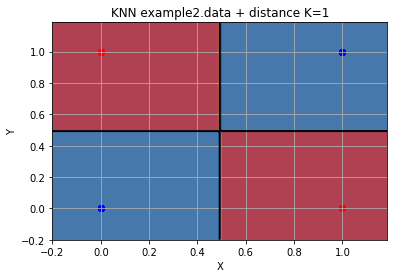

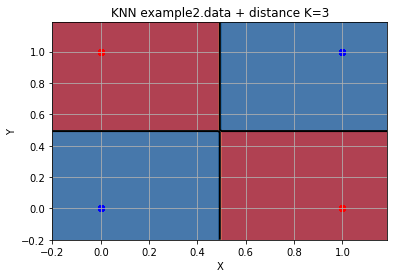

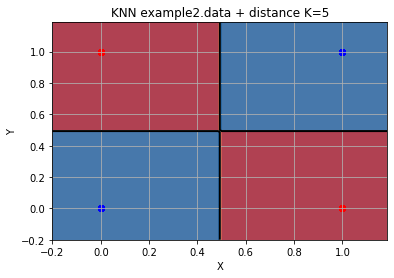

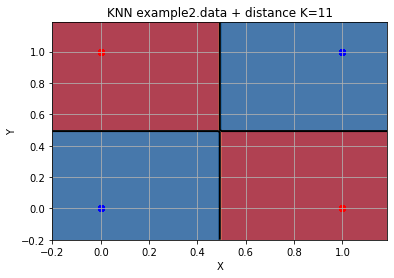

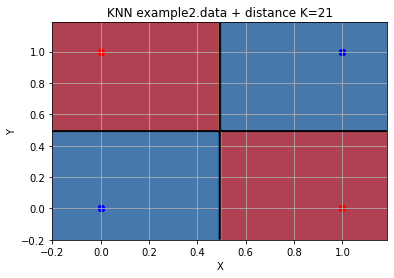

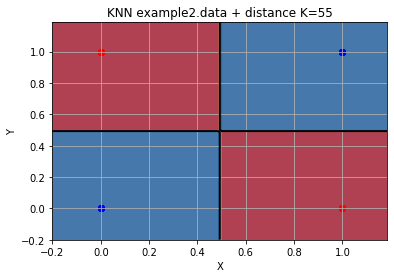

<Figure size 432x288 with 0 Axes>

In [73]:
k_vecinos=[1,3,5,11,21,55]
errores = []
for k in k_vecinos:
    estrategia = EstrategiaParticionado.ValidacionCruzada(5)
    c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform', normalizar = False)
    error = c.validacion(estrategia, d_ex4, c, seed)
    errores.append((error, k))

    estrategia.creaParticiones(d_ex4.datos, seed=seed)
    train = estrategia.particiones[-1].indicesTrain
    test = estrategia.particiones[-1].indicesTest

    datostrain= d_ex4.extraeDatos(train)
    datostest= d_ex4.extraeDatos(test)

    c.entrenamiento(datostrain, d_ex4.nominalAtributos, d_ex4.diccionarios)

    ii = estrategia.particiones[-1].indicesTrain

    plotModel(d_ex4.datos[ii, 0], d_ex4.datos[ii, 1], d_ex4.datos[ii, -1] != 0, c, "KNN example2.data + distance K="+str(k), d_ex4.diccionarios)
    plt.figure()

plotKNN(errores, 'Example2 KNN', weights_param='uniform')

Con este dataset podemos ver que todos los puntos están superpuestos unos sobre otros en distintas zonas, por ello obtenemos un error del 0%, ya que los vecinos más cercanos están exactamente en la misma posición. 

##### example3.data

K,Nuestro
1,0.03+-0.013
3,0.038+-0.026
5,0.025+-0.011
11,0.025+-0.014
21,0.035+-0.022
55,0.028+-0.012


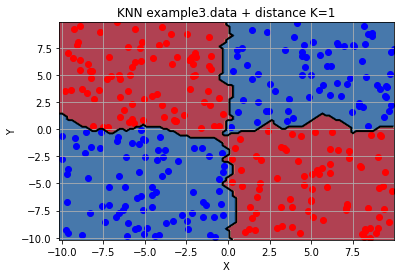

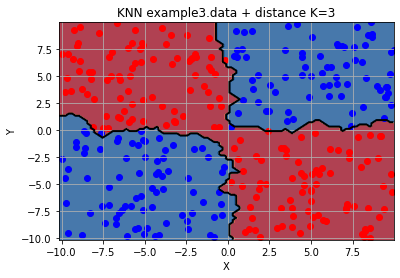

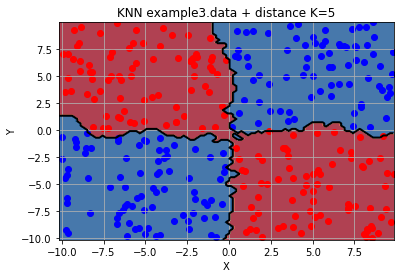

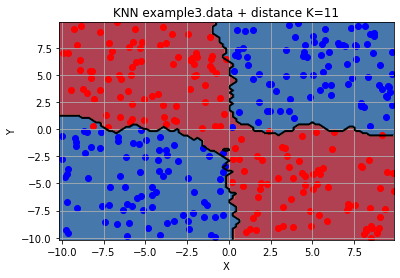

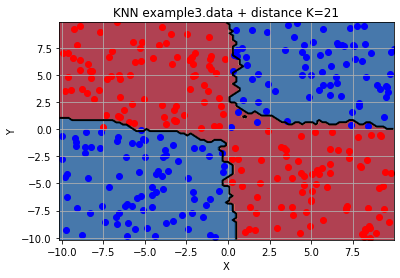

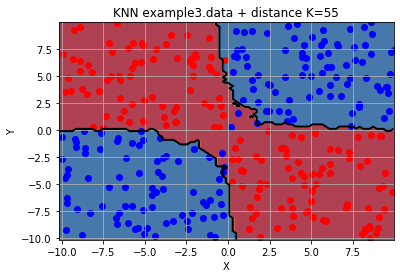

<Figure size 432x288 with 0 Axes>

In [74]:
k_vecinos=[1,3,5,11,21,55]
errores = []
for k in k_vecinos:
    estrategia = EstrategiaParticionado.ValidacionCruzada(5)
    c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform', normalizar = False)
    error = c.validacion(estrategia, d_ex5, c, seed)
    errores.append((error, k))

    estrategia.creaParticiones(d_ex5.datos, seed=seed)
    train = estrategia.particiones[-1].indicesTrain
    test = estrategia.particiones[-1].indicesTest

    datostrain= d_ex5.extraeDatos(train)
    datostest= d_ex5.extraeDatos(test)

    c.entrenamiento(datostrain, d_ex5.nominalAtributos, d_ex5.diccionarios)

    ii = estrategia.particiones[-1].indicesTrain

    plotModel(d_ex5.datos[ii, 0], d_ex5.datos[ii, 1], d_ex5.datos[ii, -1] != 0, c, "KNN example3.data + distance K="+str(k), d_ex5.diccionarios)
    plt.figure()
    
plotKNN(errores, 'Example3 KNN', weights_param='uniform')

En este dataset, visualmente podemos apreciar que las 2 zonas de clase 1 están en las esquinas inferior izquierda y superior derecha. Y las otras 2 esquinas forman un canal central que separa las zonas de 
clase 1. 

Cuando fijamos un número de vecinos bajo como k = 1,3,5. Vemos que estamos estrechando el canal que pertenece a clase 2 y por esto, el error se dispara, ya que estamos intentando clasificar como clase 1 el ruido que está en medio del canal que claramente pertenece a clase 2.

Cuando fijamos un k considerable, evitamos estrechar el canal y con ello, el ruido que hay en medio del canal es clasificado como clase 2 que son muy pocos puntos y por esta razón el error es menor


##### example4.data

K,Nuestro
1,0.04+-0.08
3,0.13+-0.075
5,0.13+-0.075
11,0.25+-0.071
21,0.33+-0.093
55,0.57+-0.136


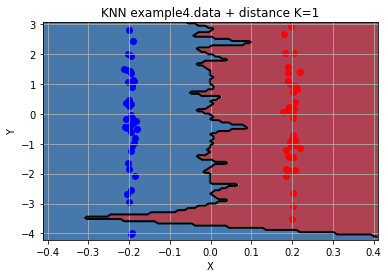

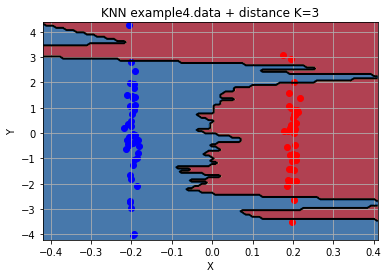

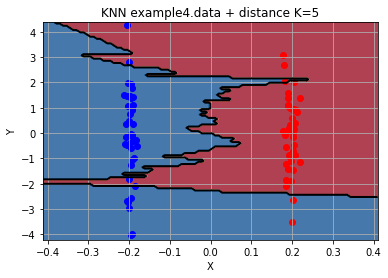

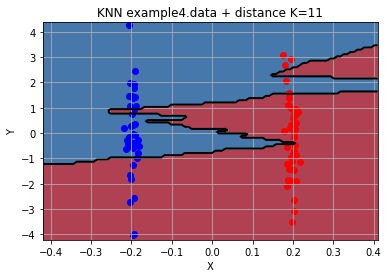

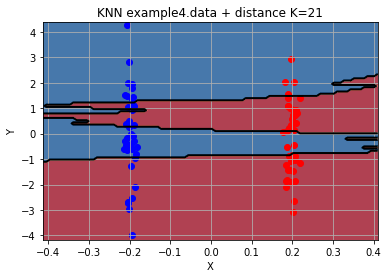

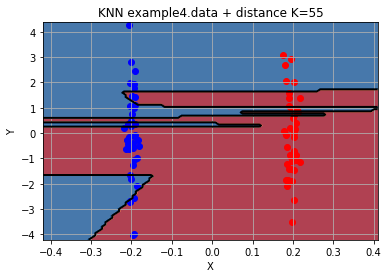

<Figure size 432x288 with 0 Axes>

In [9]:
k_vecinos=[1,3,5,11,21,55]
errores = []
for k in k_vecinos:
    estrategia = EstrategiaParticionado.ValidacionCruzada(5)
    c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform', normalizar = False)
    error = c.validacion(estrategia, d_ex6, c, seed)
    errores.append((error, k))

    estrategia.creaParticiones(d_ex6.datos, seed=seed)
    train = estrategia.particiones[-1].indicesTrain
    test = estrategia.particiones[-1].indicesTest

    datostrain= d_ex6.extraeDatos(train)
    datostest= d_ex6.extraeDatos(test)

    c.entrenamiento(datostrain, d_ex6.nominalAtributos, d_ex6.diccionarios)

    ii = estrategia.particiones[-1].indicesTrain

    plotModel(d_ex6.datos[ii, 0], d_ex6.datos[ii, 1], d_ex6.datos[ii, -1] != 0, c, "KNN example4.data + distance K="+str(k), d_ex6.diccionarios)
    plt.figure()
    
plotKNN(errores, 'Example4 KNN', weights_param='uniform')

K,Nuestro
1,0.0+-0.0
3,0.0+-0.0
5,0.0+-0.0
11,0.0+-0.0
21,0.0+-0.0
55,0.0+-0.0


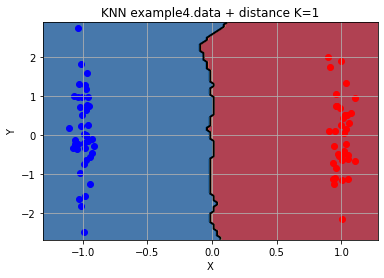

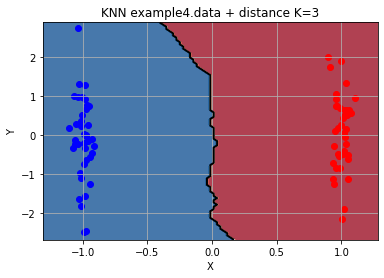

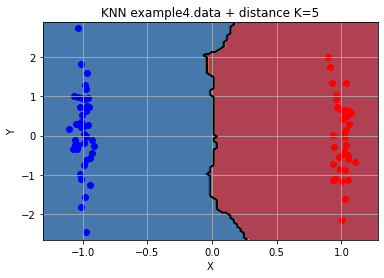

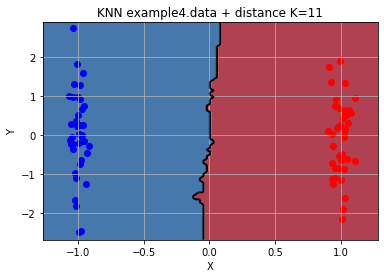

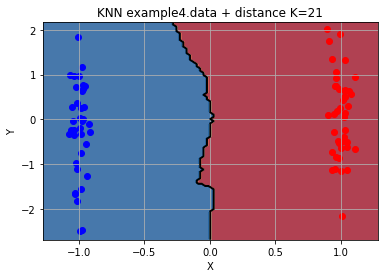

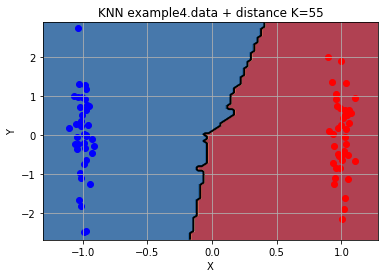

<Figure size 432x288 with 0 Axes>

In [14]:
k_vecinos=[1,3,5,11,21,55]
errores = []
for k in k_vecinos:
    estrategia = EstrategiaParticionado.ValidacionCruzada(5)
    c = Clasificador.ClasificadorVecinosProximos(k, weights='uniform', normalizar = True)
    error = c.validacion(estrategia, d_ex6_norm, c, seed)
    errores.append((error, k))

    estrategia.creaParticiones(d_ex6_norm.datos, seed=seed)
    train = estrategia.particiones[-1].indicesTrain
    test = estrategia.particiones[-1].indicesTest

    datostrain= d_ex6_norm.extraeDatos(train)
    datostest= d_ex6_norm.extraeDatos(test)

    c.entrenamiento(datostrain, d_ex6_norm.nominalAtributos, d_ex6_norm.diccionarios)

    ii = estrategia.particiones[-1].indicesTrain

    plotModel(d_ex6_norm.datos[ii, 0], d_ex6_norm.datos[ii, 1], d_ex6_norm.datos[ii, -1] != 0, c, "KNN example4.data + distance K="+str(k), d_ex6_norm.diccionarios)
    plt.figure()
    
plotKNN(errores, 'Example4 KNN Normalized', weights_param='uniform')

En este caso vemos lo importante que es normalizar los datos. Visualmente vemos como la frontera es una línea vertical en el pto 0.0. Si normalizamos los datos, prácticamente cualquier punto que esté a la derecha de la frontera será clasificado de clase 2 ya que la distancia de los k vecinos más próximos es claramente clase 2. Lo mismo ocurre para la parte izquierda.

Por ello el error es del 0%

# Apartado 2: Regresión Logística (Implementación propia y Scikit-Learn)

Antes de mostrar la evolución de la regresión logística en los diferentes datasets vamos a detallar unas observaciones que hemos visto en común en todos los datasets.

La primera observación a destacar es que los errores que obtendremos en ambas implementaciones son parecidos pero presentan algunas diferencias. En scikit, cuando llegamos a una época determinada, vemos que el error no aumenta, esto ocurre porque scikit deja de reposicionar el vector basándose en una tolerancia. Si scikit nota que el error no mejora tras n iteraciones consecutivas, deja de reposicionar la frontera, por lo tanto conseguiremos el mismo error en las próximas épocas,esto ocurre porque el gradiente alcanza el mínimo. Sin embargo cuando nos fijamos en nuestra implementación de RL, no tenemos en cuenta este detalle, y por lo tanto, la frontera mejora y empeora en un rango en cada iteración. 

También tenemos que destacar la importancia de elegir una apropiada constante de aprendizaje. Si elegimos una constante pequeña, vamos en cada iteración vamos a dar pasos más pequeños(la frontera se va perfilando más lentamente) debido a que la magnitud del gradiente a (n * magnitud del gradiente) veces más alejado.

Por el contrario, si elegimos una cte. de aprendizaje demasiado grande, estamos variando la inclinación del hiperplano más bruscamente, y por esto sería más complicado encontrar una frontera aceptable ya que estaríamos ajustándola y desajustándola continuamente.

Tras la ejecución de diferentes tasas de aprendizaje en diferentes épocas, hemos visto que lo ideal es empezar en 0.1 e ir reduciendo hasta que consigamos reducir el error lo máximo posible.

In [77]:
import sklearn.linear_model as lm
import sklearn.metrics as m

In [78]:
def generateLR(constantes, epocas, errores, errores_sk, errores_sk_sgd, dataset_name='wdbc'):
    
    title = "Error y desviación típica en {} con varias ctes y épocas".format(dataset_name)
    html_output = """<table style="width:100%">
    <caption>""" + title + """</caption>
     <tr>
    <th>Época/cte. Aprendizaje</th>
    <th>Nuestro</th>
    <th>Scikit</th>
    <th>Scikit SGD</th>
  </tr>
    """
    i = 0
    for epoca in epocas:
        for cte in constantes:
            html_output += """<tr><td>{}/{}</td><td>{}+-{}</td><td>{}+-{}</td><td>{}+-{}</td></tr>

            """.format(epoca, cte, truncate(np.mean(errores[i])), truncate(np.std(errores[i])), truncate(np.mean(errores_sk[i])), truncate(np.std(errores_sk[i])), truncate(np.mean(errores_sk_sgd[i])), truncate(np.std(errores_sk_sgd[i])))
            i += 1
            
    html_output += "</table>"
            
    display(HTML(html_output))

In [79]:
def generateLRPlot(constantes, epocas, errores, dataset_name='wdbc'):
    
    title = "Error y desviación típica en {} con varias ctes y épocas".format(dataset_name)
    html_output = """<table style="width:100%">
    <caption>""" + title + """</caption>
     <tr>
    <th>cte. Aprendizaje/Época</th>
    <th>Nuestro</th>
  </tr>
    """
    i = 0
    for cte in constantes:
        for epoca in epocas:
            html_output += """<tr><td>{}/{}</td><td>{}+-{}</td></tr>

            """.format(cte, epoca, truncate(np.mean(errores[i])), truncate(np.std(errores[i])))
            i += 1
            
    html_output += "</table>"
            
    display(HTML(html_output))

In [222]:
errores_rl_wdbc = []
errores_rl_wdbc_sk = []
errores_rl_wdbc_sk_normalized = []
errores_rl_wdbc_sk_sgd_normalized = []
errores_rl_wdbc_sk_sgd = []

errores_rl_online_shoppers = []
errores_rl_online_shoppers_sk = []
errores_rl_online_shoppers_sk_normalized = []
errores_rl_online_shoppers_sk_sgd = []
errores_rl_online_shoppers_sk_sgd_normalized = []

epocas = [10, 100, 1000]
ctes_aprendizaje = [1, 0.1, 0.01]

In [223]:
X = d_ex1.datos[:,:-1]
y = d_ex1.datos[:,-1]

for i in epocas:
    for j in ctes_aprendizaje:
        rl = lm.LogisticRegression(max_iter=i,fit_intercept=j)

        rl.fit(X, y)

        validacion = cross_val_score(rl, X, y, cv=5)
        err = 1 - np.mean((validacion))
        errores_rl_wdbc_sk.append(err)
        dt = np.std((validacion))

In [224]:
X = d_ex1_norm.datos[:,:-1]
y = d_ex1_norm.datos[:,-1]

for i in epocas:
    for j in ctes_aprendizaje:
        rl = lm.LogisticRegression(max_iter=i, fit_intercept=j)

        rl.fit(X, y)

        validacion = cross_val_score(rl, X, y, cv=5)
        err = 1 - np.mean((validacion))
        errores_rl_wdbc_sk_normalized.append(err)
        dt = np.std((validacion))

In [225]:
X = d_ex1.datos[:,:-1]
y = d_ex1.datos[:,-1]

for i in epocas:
    for j in ctes_aprendizaje:
        rl = lm.SGDClassifier(max_iter=i, learning_rate = 'constant', eta0=j)

        rl.fit(X, y)

        validacion = cross_val_score(rl, X, y, cv=5)
        err = 1 - np.mean((validacion))
        errores_rl_wdbc_sk_sgd.append(err)
        dt = np.std((validacion))

In [226]:
X = d_ex1_norm.datos[:,:-1]
y = d_ex1_norm.datos[:,-1]

for i in epocas:
    for j in ctes_aprendizaje:
        rl = lm.SGDClassifier(max_iter=i,learning_rate = 'constant', eta0=j)

        rl.fit(X, y)

        validacion = cross_val_score(rl, X, y, cv=5)
        err = 1 - np.mean((validacion))
        errores_rl_wdbc_sk_sgd_normalized.append(err)
        dt = np.std((validacion))

In [227]:
encAtributos = preprocessing.OneHotEncoder(categorical_features=d_ex2.nominalAtributos[:-1],sparse=False)
X = encAtributos.fit_transform(d_ex2.datos[:, :-1])

y = d_ex2.datos[:,-1]

for i in epocas:
    for j in ctes_aprendizaje:
        rl = lm.LogisticRegression(max_iter=i,fit_intercept=j)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed, stratify=y)
        rl.fit(X_train, y_train)

        err = 1 - rl.score(X_test, y_test)
        
        errores_rl_online_shoppers_sk.append(err)
        dt = np.std(err)

In [228]:
encAtributos = preprocessing.OneHotEncoder(categorical_features=d_ex2_norm.nominalAtributos[:-1],sparse=False)
X = encAtributos.fit_transform(d_ex2_norm.datos[:, :-1])

y = d_ex2_norm.datos[:,-1]

for i in epocas:
    for j in ctes_aprendizaje:
        rl = lm.LogisticRegression(max_iter=i,fit_intercept=j)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed, stratify=y)
        rl.fit(X_train, y_train)

        err = 1 - rl.score(X_test, y_test)
        
        errores_rl_online_shoppers_sk_normalized.append(err)
        dt = np.std(err)

In [229]:
encAtributos = preprocessing.OneHotEncoder(categorical_features=d_ex2.nominalAtributos[:-1],sparse=False)
X = encAtributos.fit_transform(d_ex2.datos[:, :-1])
y = d_ex2.datos[:,-1]

for i in epocas:
    for j in ctes_aprendizaje:
        rl = lm.SGDClassifier(max_iter=i, learning_rate = 'constant', eta0=j)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed, stratify=y)
        rl.fit(X_train, y_train)

        err = 1 - rl.score(X_test, y_test)
        
        errores_rl_online_shoppers_sk_sgd.append(err)
        dt = np.std(err)

In [230]:
encAtributos = preprocessing.OneHotEncoder(categorical_features=d_ex2_norm.nominalAtributos[:-1],sparse=False)
X = encAtributos.fit_transform(d_ex2_norm.datos[:, :-1])
y = d_ex2_norm.datos[:,-1]

for i in epocas:
    for j in ctes_aprendizaje:
        rl = lm.SGDClassifier(max_iter=i, learning_rate = 'constant', eta0=j)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed, stratify=y)
        rl.fit(X_train, y_train)

        err = 1 - rl.score(X_test, y_test)
        
        errores_rl_online_shoppers_sk_sgd_normalized.append(err)
        dt = np.std(err)

In [89]:
# constante de aprendizaje: [1,0.1,0.01]
# nEpocas: [10,100,1000]

### Pruebas con wdbc.data datos no normalizados

In [276]:
errores_rl_wdbc = []
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=10, constante=1)
errorA = c.validacion(estrategia, d_ex1, c, seed)
errores_rl_wdbc.append(errorA)

In [147]:
%autoreload 2
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [277]:
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=1)
errorA = c.validacion(estrategia, d_ex1, c, seed)
errores_rl_wdbc.append(errorA)

In [278]:
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=1)
errorA = c.validacion(estrategia, d_ex1, c, seed)
errores_rl_wdbc.append(errorA)

In [279]:
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=10, constante=0.1)
errorA = c.validacion(estrategia, d_ex1, c, seed)
errores_rl_wdbc.append(errorA)

In [280]:
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=0.1)
errorA = c.validacion(estrategia, d_ex1, c, seed)
errores_rl_wdbc.append(errorA)

In [281]:
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=0.1)
errorA = c.validacion(estrategia, d_ex1, c, seed)
errores_rl_wdbc.append(errorA)

In [282]:
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=10, constante=0.01)
errorA = c.validacion(estrategia, d_ex1, c, seed)
errores_rl_wdbc.append(errorA)

In [283]:
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=0.01)
errorA = c.validacion(estrategia, d_ex1, c, seed)
errores_rl_wdbc.append(errorA)

In [284]:
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=0.01)
errorA = c.validacion(estrategia, d_ex1, c, seed)
errores_rl_wdbc.append(errorA)

In [285]:
generateLR(ctes_aprendizaje, epocas, errores_rl_wdbc, errores_rl_wdbc_sk, errores_rl_wdbc_sk_sgd, dataset_name='wdbc')

Época/cte. Aprendizaje,Nuestro,Scikit,Scikit SGD
10/1,0.109+-0.056,0.074+-0.0,0.261+-0.0
10/0.1,0.09+-0.016,0.074+-0.0,0.13+-0.0
10/0.01,0.084+-0.025,0.074+-0.0,0.193+-0.0
100/1,0.105+-0.016,0.049+-0.0,0.175+-0.0
100/0.1,0.109+-0.039,0.049+-0.0,0.097+-0.0
100/0.01,0.072+-0.022,0.049+-0.0,0.19+-0.0
1000/1,0.151+-0.06,0.049+-0.0,0.16+-0.0
1000/0.1,0.118+-0.05,0.049+-0.0,0.113+-0.0
1000/0.01,0.076+-0.014,0.049+-0.0,0.184+-0.0


Para el caso de RL en wdbc.data hemos probado para diferentes épocas y constantes de aprendizaje. Es preciso destacar que el mejor valor que obtenemos es para el caso de 100 épocas y una constante de 0.01.

Vemos que es impoprtante realizar un gran número de épocas para lograr que la frontera de decisión separe lo más precisamente las 2 clases. Pero también es importante no pasarnos con este parámetro ya que estaríamos ajustando el modelo demasiado para los datos de train evitando que pueda generalizar para nuevas clasificaciones de test pudiendo causar de este modo overfitting. Por ello es importante acertar en la elección de este parámetro. Adicionalmente hemos aprovechado el pequeño tamaño del dataset para realizar validación cruzada y de esta forma ayudar a reducir el overfitting. 

Para este dataset, vemos que con 100 épocas logramos los mejores resultados, tomando como base la constante de aprendizaje 0.01. 

En cuanto a la constante de aprendizaje podemos ver que 1 es demasiado grande y que 0.01 parece una elección más positiva y que para la dimensión de nuestro dataset se trata de un valor adecuado.

En cuanto a la comparativa con scikit, los datos son bastante parecidos en ambas implementaciones, no obstante en scikit cuando llegamos a la epoca 100, vemos que el error no aumenta, por lo comentado en la intrducción. 

Como indicamos anteriormente, la época 100 es con la que conseguimos mejor error al igual que ocurre con scikit. La diferencia, es que nosotros reintentamos posicionar el hiperplano hasta llegar a la última de las épocas empeorando ligeramente el error, sin embargo scikit ha notado que a partir de la época 100, el error no mejora por lo que deja de recolocar la frontera consiguiendo un error constante de 0.049.

Es preciso destacar que la implementacion de regresion logistica estandard de sklearn, no permite establecer una constante de aprendizaje, ya que la propia clase se encarga de seleccionar la constante más adecuada. Es por ello por lo que hemos usado la clase SGD, para poder introducir las diferentes constantes y ver la evolución.

Gracias a esto hemos conseguido errores mucho mas similares a los de nuestra implementración, ya que en este caso no se tiene en cuenta el valor de la tolerancia y por lo tanto, la frontera continúa reposicionándose como ocurre en nuestra implementación.

### Pruebas con wdbc.data datos normalizados

In [178]:
errores_rl_wdbc = []
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=10, constante=1)
errorA = c.validacion(estrategia, d_ex1_norm, c, seed)
errores_rl_wdbc.append(errorA)

In [179]:
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=1)
errorA = c.validacion(estrategia, d_ex1_norm, c, seed)
errores_rl_wdbc.append(errorA)

In [180]:
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=1)
errorA = c.validacion(estrategia, d_ex1_norm, c, seed)
errores_rl_wdbc.append(errorA)

In [181]:
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=10, constante=0.1)
errorA = c.validacion(estrategia, d_ex1_norm, c, seed)
errores_rl_wdbc.append(errorA)

In [182]:
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=0.1)
errorA = c.validacion(estrategia, d_ex1_norm, c, seed)
errores_rl_wdbc.append(errorA)

In [183]:
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=0.1)
errorA = c.validacion(estrategia, d_ex1_norm, c, seed)
errores_rl_wdbc.append(errorA)

In [184]:
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=10, constante=0.01)
errorA = c.validacion(estrategia, d_ex1_norm, c, seed)
errores_rl_wdbc.append(errorA)

In [185]:
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=0.01)
errorA = c.validacion(estrategia, d_ex1_norm, c, seed)
errores_rl_wdbc.append(errorA)

In [186]:
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=0.01)
errorA = c.validacion(estrategia, d_ex1_norm, c, seed)
errores_rl_wdbc.append(errorA)

In [187]:
generateLR(ctes_aprendizaje, epocas, errores_rl_wdbc, errores_rl_wdbc_sk_normalized, errores_rl_wdbc_sk_sgd_normalized, dataset_name='wdbc')

Época/cte. Aprendizaje,Nuestro,Scikit,Scikit SGD
10/1,0.032+-0.012,0.021+-0.0,0.035+-0.0
10/0.1,0.033+-0.01,0.021+-0.0,0.039+-0.0
10/0.01,0.03+-0.007,0.021+-0.0,0.023+-0.0
100/1,0.028+-0.015,0.021+-0.0,0.047+-0.0
100/0.1,0.028+-0.014,0.021+-0.0,0.03+-0.0
100/0.01,0.037+-0.015,0.021+-0.0,0.028+-0.0
1000/1,0.018+-0.0,0.021+-0.0,0.044+-0.0
1000/0.1,0.023+-0.011,0.021+-0.0,0.03+-0.0
1000/0.01,0.028+-0.013,0.021+-0.0,0.026+-0.0


Podemos ver que tras normalizar, los errores se han reducido considerablemente, y esto es debido a que pese a que la regresión es prácticamente independiente de la normalización de los datos, en el dataset de 'wdbc.data' hay saltos muy considerables entre ellos. Por ello normalizando podemos reducir el error hasta en un factor de 4, ajustando mucho mejor. 

Como vemos los errores de la regresión con scikit mejora considerablemente también, aunque por algún motivo el clasificador SGD no aprecia diferencias de normalizado a sin normalizar. 

cte. Aprendizaje/Época,Nuestro
1/10,0.483+-0.066
1/100,0.525+-0.051
1/1000,0.483+-0.032
0.1/10,0.5+-0.05
0.1/100,0.505+-0.082
0.1/1000,0.493+-0.039
0.01/10,0.497+-0.037
0.01/100,0.565+-0.046
0.01/1000,0.502+-0.037


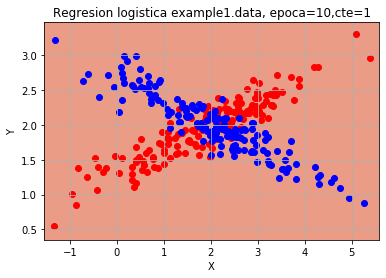

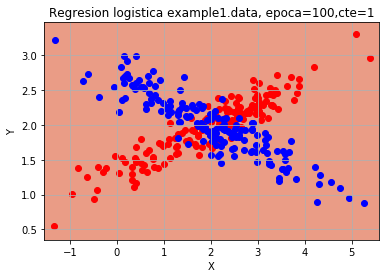

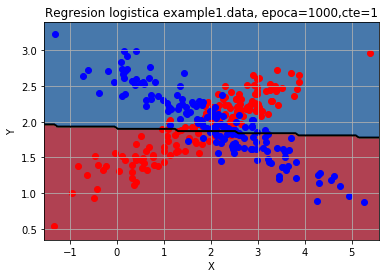

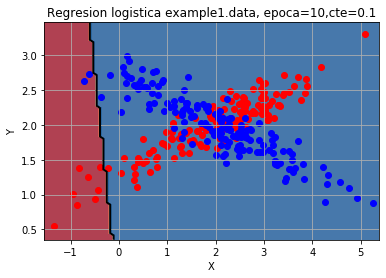

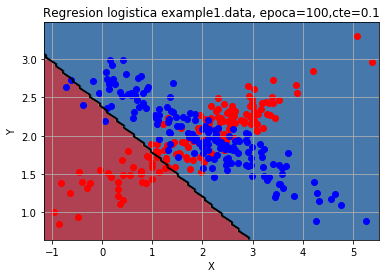

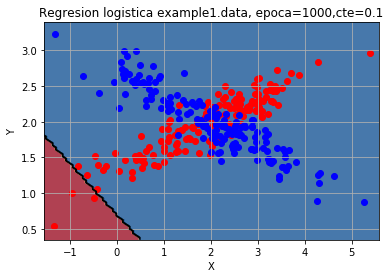

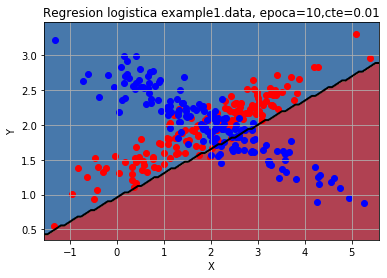

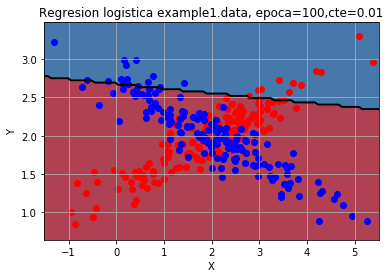

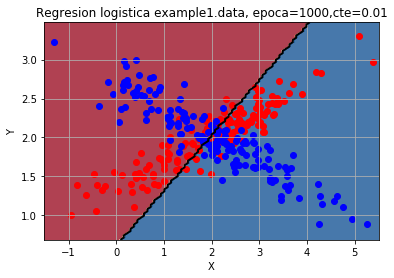

<Figure size 432x288 with 0 Axes>

In [144]:
errores = []
for j in ctes_aprendizaje:
    for i in epocas:
        estrategia = EstrategiaParticionado.ValidacionCruzada(5)
        c = Clasificador.ClasificadorRegresionLogistica(nEpocas=i, constante=j)
        error = c.validacion(estrategia, d_ex3, c, seed)
        errores.append(error)

        estrategia.creaParticiones(d_ex3.datos, seed=seed)
        train = estrategia.particiones[-1].indicesTrain
        test = estrategia.particiones[-1].indicesTest

        datostrain= d_ex3.extraeDatos(train)
        datostest= d_ex3.extraeDatos(test)

        c.entrenamiento(datostrain, d_ex3.nominalAtributos, d_ex3.diccionarios)

        ii = estrategia.particiones[-1].indicesTrain

        plotModel(d_ex3.datos[ii, 0], d_ex3.datos[ii, 1], d_ex3.datos[ii, -1] != 0, c, "Regresion logistica example1.data, epoca="+str(i)+ ",cte="+str(j)+"", d_ex3.diccionarios)
        plt.figure()

generateLRPlot(ctes_aprendizaje, epocas, errores, dataset_name='example1')

Como se puede comprobar, los datos de este dataset no son separables linealmente, por lo que es muy dificil conseguir un error del modelo inferior al 40%, ya que es imposible trazar una frontera que separe a las 2 clases sin lugar a equivocación.

Vemos que según van avanzando las épocas, la frontera intenta posicionarse en la intersección de las nubes de puntos de ambas clases, consigueindo clasificar alrededor del 50% de los casos de forma correcta, por lo que el error ronda el 50% (0.502).

cte. Aprendizaje/Época,Nuestro
1/10,0.49+-0.027
1/100,0.503+-0.056
1/1000,0.525+-0.043
0.1/10,0.5+-0.058
0.1/100,0.472+-0.183
0.1/1000,0.5+-0.073
0.01/10,0.632+-0.19
0.01/100,0.497+-0.106
0.01/1000,0.602+-0.194


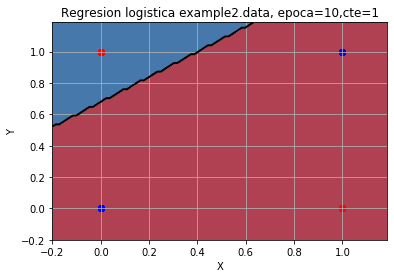

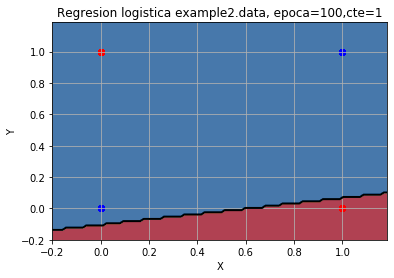

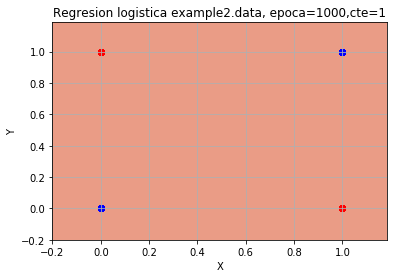

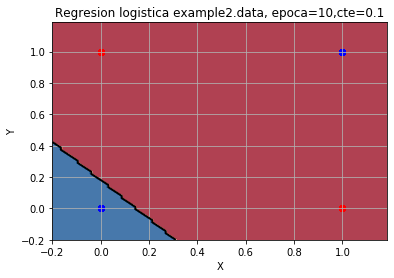

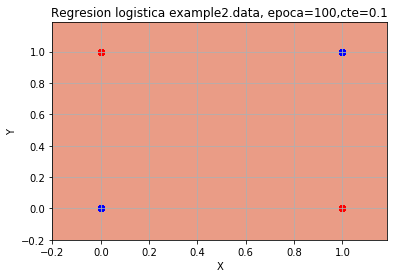

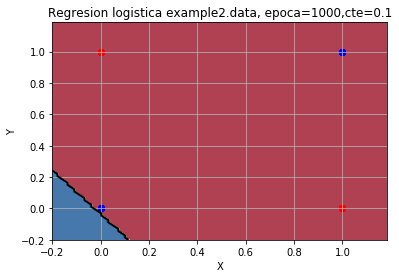

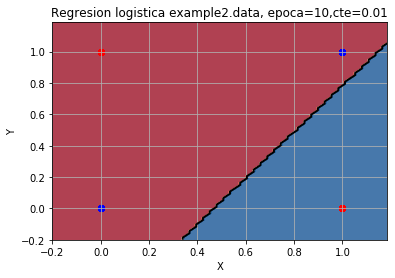

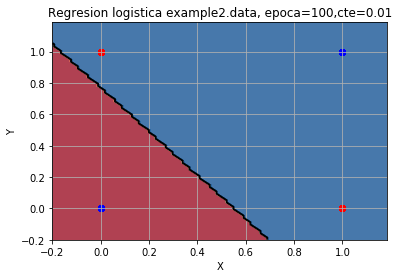

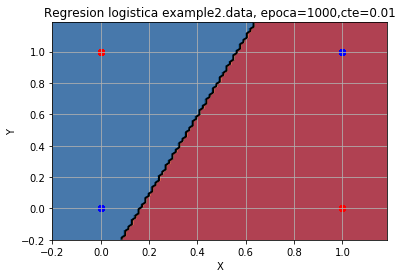

<Figure size 432x288 with 0 Axes>

In [145]:
errores = []
for j in ctes_aprendizaje:
    for i in epocas:
    
        estrategia = EstrategiaParticionado.ValidacionCruzada(5)
        c = Clasificador.ClasificadorRegresionLogistica(nEpocas=i, constante=j)
        error = c.validacion(estrategia, d_ex4, c, seed)
        errores.append(error)

        estrategia.creaParticiones(d_ex4.datos, seed=seed)
        train = estrategia.particiones[-1].indicesTrain
        test = estrategia.particiones[-1].indicesTest

        datostrain= d_ex4.extraeDatos(train)
        datostest= d_ex4.extraeDatos(test)

        c.entrenamiento(datostrain, d_ex4.nominalAtributos, d_ex4.diccionarios)

        ii = estrategia.particiones[-1].indicesTrain

        plotModel(d_ex4.datos[ii, 0], d_ex4.datos[ii, 1], d_ex4.datos[ii, -1] != 0, c, "Regresion logistica example2.data, epoca="+str(i)+ ",cte="+str(j)+"", d_ex4.diccionarios)
        plt.figure()

generateLRPlot(ctes_aprendizaje, epocas, errores, dataset_name='example2')

Como se puede observar, este es el típico problema de clasificación que no es separable linealmente y por ello no hay forma de trazar una frontera lineal que separe ambas clases. Esta es la razón por la que no podemos bajar de un 40% de error, en ninguna de las épocas con las diferentes ctes de aprendizaje.

cte. Aprendizaje/Época,Nuestro
1/10,0.478+-0.046
1/100,0.507+-0.048
1/1000,0.488+-0.062
0.1/10,0.512+-0.086
0.1/100,0.49+-0.04
0.1/1000,0.493+-0.064
0.01/10,0.508+-0.032
0.01/100,0.528+-0.051
0.01/1000,0.488+-0.047


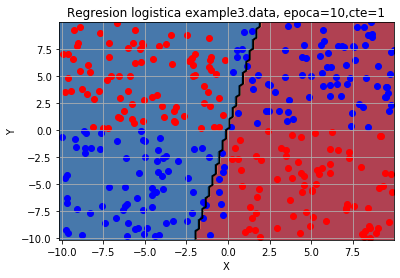

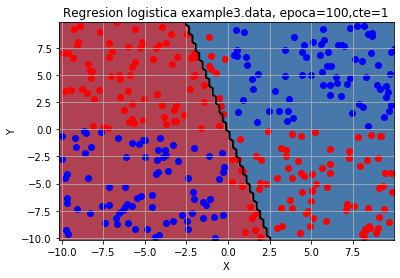

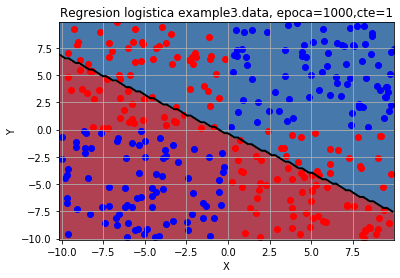

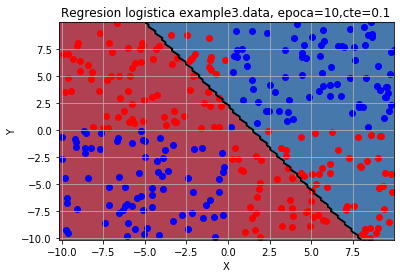

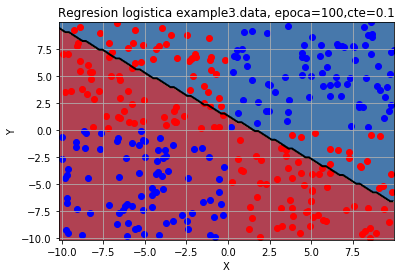

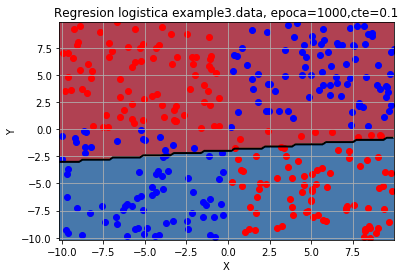

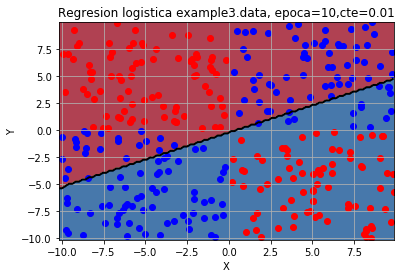

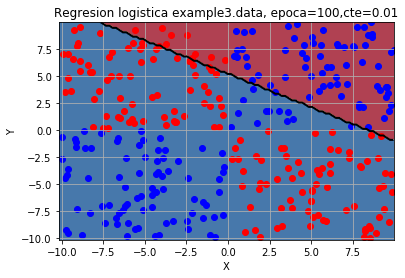

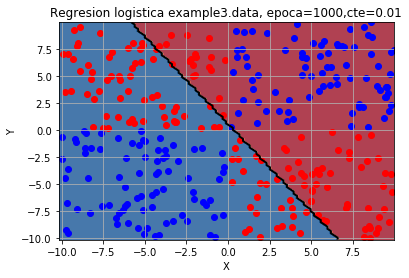

<Figure size 432x288 with 0 Axes>

In [188]:
errores = []
for j in ctes_aprendizaje:
    for i in epocas:
        estrategia = EstrategiaParticionado.ValidacionCruzada(5)
        c = Clasificador.ClasificadorRegresionLogistica(nEpocas=i, constante=j)
        error = c.validacion(estrategia, d_ex5, c, seed)
        errores.append(error)
        

        estrategia.creaParticiones(d_ex5.datos, seed=seed)
        train = estrategia.particiones[-1].indicesTrain
        test = estrategia.particiones[-1].indicesTest

        datostrain= d_ex5.extraeDatos(train)
        datostest= d_ex5.extraeDatos(test)

        c.entrenamiento(datostrain, d_ex5.nominalAtributos, d_ex5.diccionarios)

        ii = estrategia.particiones[-1].indicesTrain

        plotModel(d_ex5.datos[ii, 0], d_ex5.datos[ii, 1], d_ex5.datos[ii, -1] != 0, c, "Regresion logistica example3.data, epoca="+str(i)+ ",cte="+str(j)+"", d_ex5.diccionarios)
        plt.figure()

generateLRPlot(ctes_aprendizaje, epocas, errores, dataset_name='example3')

Al igual que sucede con el dataset anterior, la distribución de los puntos impide trazar una frontera lineal para separar las 2 clases, por esta razón no podemos bajar del 40% de error.

Podemos ver como influye la decisión de la constante de aprendizaje para la evolución de las distintas épocas. 

Con cte = 1, vemos como la frontera en la época 10 se sitúa verticalmente y en la época 100 le ha dado tiempo a pivotarse hasta la horizontal. Ya que este problema no es  separable por regresión logística, en la época 1000 el hiperplano se posiciona atravesando la diagonal de la gráfica.

Con cte=0.1, vemos como la frontera se posiciona en la diagonal inversa al caso anterior, y esta vez se va perfinaldo hasta situar la frontera en y =0.0, consiguiendo de esta forma un error cercano al 50%. 

Finalmente con cte= 0.01 vemos como tras la 10º época, la frontera se va posicionando al igual que en el caso anterior tratando de separar las clases mediante una diagonal.




cte. Aprendizaje/Época,Nuestro
1/10,0.0+-0.0
1/100,0.0+-0.0
1/1000,0.0+-0.0
0.1/10,0.0+-0.0
0.1/100,0.0+-0.0
0.1/1000,0.0+-0.0
0.01/10,0.04+-0.08
0.01/100,0.0+-0.0
0.01/1000,0.0+-0.0


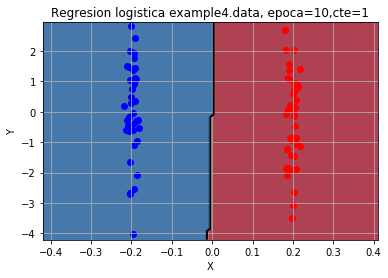

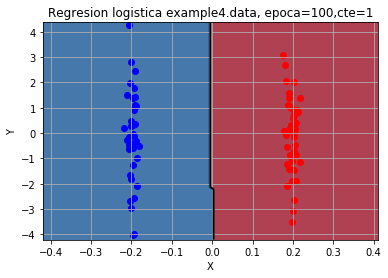

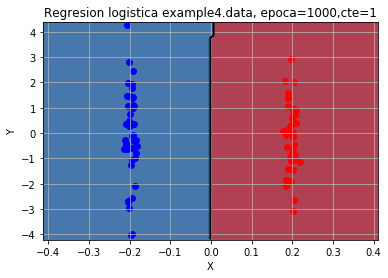

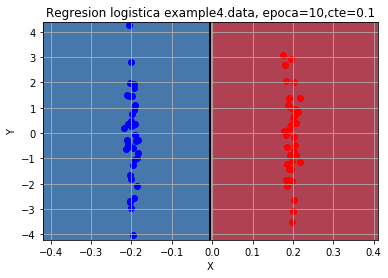

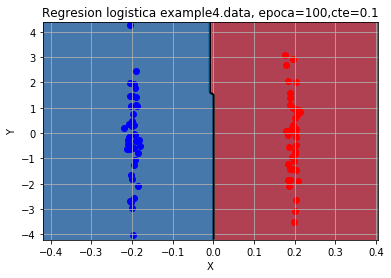

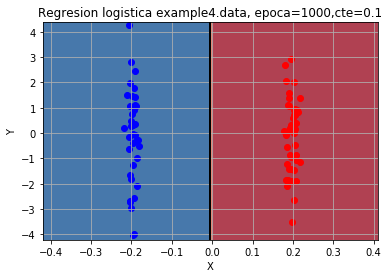

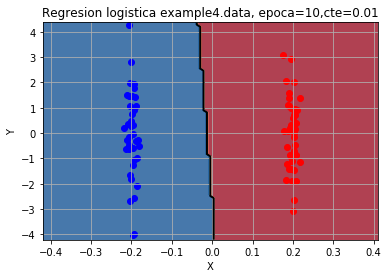

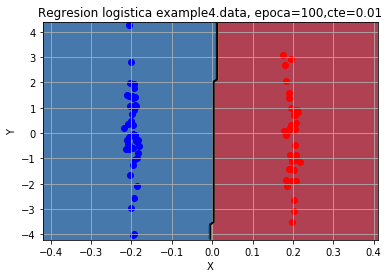

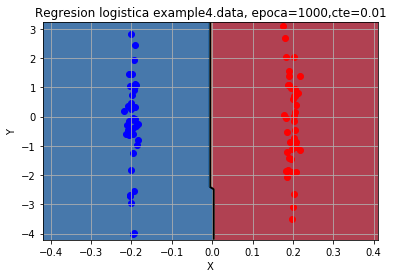

<Figure size 432x288 with 0 Axes>

In [189]:
errores = []
for j in ctes_aprendizaje:
    for i in epocas:
        estrategia = EstrategiaParticionado.ValidacionCruzada(5)
        c = Clasificador.ClasificadorRegresionLogistica(nEpocas=i, constante=j)
        error = c.validacion(estrategia, d_ex6, c, seed)
        errores.append(error)
       

        estrategia.creaParticiones(d_ex6.datos, seed=seed)
        train = estrategia.particiones[-1].indicesTrain
        test = estrategia.particiones[-1].indicesTest

        datostrain= d_ex6.extraeDatos(train)
        datostest= d_ex6.extraeDatos(test)

        c.entrenamiento(datostrain, d_ex6.nominalAtributos, d_ex6.diccionarios)

        ii = estrategia.particiones[-1].indicesTrain

        plotModel(d_ex6.datos[ii, 0], d_ex6.datos[ii, 1], d_ex6.datos[ii, -1] != 0, c, "Regresion logistica example4.data, epoca="+str(i)+ ",cte="+str(j)+"", d_ex6.diccionarios)
        plt.figure()

generateLRPlot(ctes_aprendizaje, epocas, errores, dataset_name='example4')

Este dataset es ideal para clasificarlo usando regresión logística. Podemos ver claramente que la frontera entre ambas clases es una línea vertical desde el punto x=0, por lo que el error que conseguimos es 0%.

Vemos que en en las primeras 10 épocas para las ctes 0.01 y 0.1, la frontera está aún un poco inclinada, esto ocurre debido a que todavía no ha tenido tiempo de posicionarse, pero tras la ejecución de las 1000 épocas, vemos que para cualquier constante de aprendizaje, la frontera se sitúa justo en medio de las 2 clases.

Por esto recalcamos nuevamente la importancia de emplear las épocas suficientes para realizar una correcta clasificación sin llegar a hacer overfitting.

En este problema en particular, habría sido suficiente con 10 épocas, ya que como los puntos de las 2 clases están tan separados unos de otros, no importa que la frontera esté un poco inclinada, ya que seguirá clasificando todos los ejemplos correctamente.

### Pruebas con online_shoppers.data sin normalizar

In [242]:
errores_rl_online_shoppers = []
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=10, constante=1)
errorA = c.validacion(estrategia, d_ex2, c, seed=seed, oneHot=True)
errores_rl_online_shoppers.append(errorA)

In [243]:
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=1)
errorA = c.validacion(estrategia, d_ex2, c, seed=seed, oneHot=True)
errores_rl_online_shoppers.append(errorA)

In [244]:
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=1)
errorA = c.validacion(estrategia, d_ex2, c, seed=seed, oneHot=True)
errores_rl_online_shoppers.append(errorA)

In [245]:
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=10, constante=0.1)
errorB = c.validacion(estrategia, d_ex2, c, seed=seed, oneHot=True)
errores_rl_online_shoppers.append(errorB)

In [246]:
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=0.1)
errorC = c.validacion(estrategia, d_ex2, c, seed=seed, oneHot=True)
errores_rl_online_shoppers.append(errorC)

In [247]:
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=0.1)
errorD = c.validacion(estrategia, d_ex2, c, seed=seed, oneHot=True)
errores_rl_online_shoppers.append(errorD)

In [248]:
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=10, constante=0.01)
errorE = c.validacion(estrategia, d_ex2, c, seed=seed, oneHot=True)
errores_rl_online_shoppers.append(errorE)

In [249]:
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=0.01)
errorF = c.validacion(estrategia, d_ex2, c, seed=seed, oneHot=True)
errores_rl_online_shoppers.append(errorF)

In [250]:
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=0.01)
errorG = c.validacion(estrategia, d_ex2, c, seed=seed, oneHot=True)
errores_rl_online_shoppers.append(errorG)

In [251]:
generateLR(ctes_aprendizaje, epocas, errores_rl_online_shoppers, errores_rl_online_shoppers_sk, errores_rl_online_shoppers_sk_sgd, dataset_name='online_shoppers')

Época/cte. Aprendizaje,Nuestro,Scikit,Scikit SGD
10/1,0.115+-0.0,0.117+-0.0,0.14+-0.0
10/0.1,0.108+-0.0,0.113+-0.0,0.127+-0.0
10/0.01,0.141+-0.0,0.113+-0.0,0.742+-0.0
100/1,0.128+-0.0,0.119+-0.0,0.124+-0.0
100/0.1,0.116+-0.0,0.121+-0.0,0.758+-0.0
100/0.01,0.124+-0.0,0.121+-0.0,0.129+-0.0
1000/1,0.111+-0.0,0.119+-0.0,0.127+-0.0
1000/0.1,0.109+-0.0,0.112+-0.0,0.122+-0.0
1000/0.01,0.13+-0.0,0.116+-0.0,0.137+-0.0


Para el caso de RL en **online_shoppers.data** hemos probado para diferentes épocas y constantes de aprendizaje y hemos obtenido el mejor error en la época 100 con cte de aprendizaje 1.

A diferencia de wdbc.data, podemos comprobar que la ejecución de 100 épocas no son suficientes para establecer la frontera óptima, vemos que es cuando llegamos a la época 1000 con constante de aprendizaje = 0.01 cuando obtenemos el menor error (0.109).

Vemos que los 3 clasificadores salen muy similares, ya que comparten una semilla común, y ajustan correctamente salvando las distancias. Como comentamos, la regresión de scikit no permite establecer una constante, sino que él mismo la ajusta y por ello salen unos errores muy similares en esa columna. Por el contrario SGD es el más similar a nuestro clasificador, ya que utiliza las constantes de aprendizaje que le asignamos. Pese a esto, puede darse que la evolución del posicionamiento de la frontera no siga el mismo patrón en los 3 clasificadores.

No obstante, tras la ejecución de 1000 épocas con cte = 0.01 obtenemos errores del 13 % en nuestro clasificador y 11.6 % en scikit, al igual que SGD qe ronda el 14%. 

### Pruebas con online_shoppers.data normalizados

In [252]:
errores_rl_online_shoppers=[]

In [253]:
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=10, constante=1)
errorA = c.validacion(estrategia, d_ex2_norm, c, seed=seed, oneHot=True)
errores_rl_online_shoppers.append(errorA)

In [254]:
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=1)
errorA = c.validacion(estrategia, d_ex2_norm, c, seed=seed, oneHot=True)
errores_rl_online_shoppers.append(errorA)

In [255]:
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=1)
errorA = c.validacion(estrategia, d_ex2_norm, c, seed=seed, oneHot=True)
errores_rl_online_shoppers.append(errorA)

In [256]:
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=10, constante=0.1)
errorB = c.validacion(estrategia, d_ex2_norm, c, seed=seed, oneHot=True)
errores_rl_online_shoppers.append(errorB)

In [257]:
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=0.1)
errorC = c.validacion(estrategia, d_ex2_norm, c, seed=seed, oneHot=True)
errores_rl_online_shoppers.append(errorC)

In [258]:
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=0.1)
errorD = c.validacion(estrategia, d_ex2_norm, c, seed=seed, oneHot=True)
errores_rl_online_shoppers.append(errorD)

In [259]:
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=10, constante=0.01)
errorE = c.validacion(estrategia, d_ex2_norm, c, seed=seed, oneHot=True)
errores_rl_online_shoppers.append(errorE)

In [260]:
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=0.01)
errorF = c.validacion(estrategia, d_ex2_norm, c, seed=seed, oneHot=True)
errores_rl_online_shoppers.append(errorF)

In [261]:
estrategia = EstrategiaParticionado.ValidacionSimple()
c = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=0.01)
errorG = c.validacion(estrategia, d_ex2_norm, c, seed=seed, oneHot=True)
errores_rl_online_shoppers.append(errorG)

In [262]:
generateLR(ctes_aprendizaje, epocas, errores_rl_online_shoppers, errores_rl_online_shoppers_sk_normalized,errores_rl_online_shoppers_sk_sgd_normalized, dataset_name='online_shoppers')

Época/cte. Aprendizaje,Nuestro,Scikit,Scikit SGD
10/1,0.124+-0.0,0.112+-0.0,0.163+-0.0
10/0.1,0.116+-0.0,0.119+-0.0,0.118+-0.0
10/0.01,0.124+-0.0,0.115+-0.0,0.116+-0.0
100/1,0.204+-0.0,0.113+-0.0,0.149+-0.0
100/0.1,0.103+-0.0,0.119+-0.0,0.117+-0.0
100/0.01,0.118+-0.0,0.118+-0.0,0.113+-0.0
1000/1,0.126+-0.0,0.117+-0.0,0.149+-0.0
1000/0.1,0.109+-0.0,0.117+-0.0,0.118+-0.0
1000/0.01,0.119+-0.0,0.111+-0.0,0.12+-0.0


Como podemos ver, en este caso los errores con y sin normalización salen muy similares, debido a que a diferencia de wdbc, las columnas de los datos apenas son dispares entre ellos, por lo que en el dataset apenas se nota diferencia entre normalizar y no normalizar. Es por esto que la recta de regresión es capaz de ajustar los datos correctamente en ambos casos.

Como conclusión, nos pareció curioso que la normalización afectase a algunos datasets en regresión frente a lo que se comentó en primera instancia en clase de que sería totalmente indpendiente, y puesto que la regresión únicamente se basa en comparar los datos de cada columna entre ellos para calcular cada uno de las componentes del vector del hiperplano en lugar de calcular distancias euclídeas, los errores son menos notorios. Pese a esto, si tenemos un dataset con una diferencia mínima entre sus puntos, la regresión será capaz de encontrar un ajuste mejor. 

Por último, nos dimos cuenta de que si el valor que introduccimos en la función sigmoidal es muy grande, se desborda dando una excepción por overflow. En un principio asignábamos directamente el valor 0.0, pero tras estudiar el comportamiento de la función exponencial y sus asíntotas, nos dimos cuenta de que era más eficiente asignar 1.0 cuando el número que se desborda es positivo y 0.0 cuando es negativo, mejorando muy ligeramente el error de la predicción. 

### Preconsideraciones

Como consideraciones finales, queríamos comentar cómo se han llevado a cabo los
diferentes ajustes en el clasifica para mejorar la precisión de este. En primer lugar, hemos
hecho modificaciones en Datos.py respecto a la columna ‘Month’ para permitir que,
cuando se detecte esta columna se ordenen los meses en orden natural. Pusimos
detectar automáticamente la column month, pues es una columna que consideramos que
se repetirá muy frecuentemente en muchos datasets. Esta consideración la tuvimos en
cuenta para ponderar por igual la distancia entre enero y febrero, y diciembre y enero, por
ejemplo. Es decir, que no sea la distancia 1 - 12, sino que mediante módulos,
consigamos obtener una distancia 1 puesto que es la natural que nos marca nuestro
calendario.


Por otra parte, en las consideraciones de la distancia uniform o distance, tuvimos en
cuenta la primera para conseguir ponderar todas las distancias por igual, quedándonos
con las k mejores con menor distancia, mientras que en distance, al tratar de hacer las
distancias proporcionales a la distancia de los atributos, lo calculábamos mediante 1/
distancia_euclidea, lo cual nos obliga a no coger los k mejores, sino a coger los k últimos
(con una distancia mayor, al salir 1/algo muy pequeño muy grande).


También como añadido decidimos implementar nuestra propia función de
distancia_euclidea, para poder tener toda la auditoría de nuestro código, y controlar
cualquier posible incorrección. Somos conocedores de que hay 3 funciones en diversas
librerías que calculan la distancia (numpy, sklearn y scipy), cada una con un
procesamiento de datos distinto que puede que obtengan un ligeramente mejor
resultado, pero preferimos mantener nuestro clasifica ajeno a librerías externas.


Como última consideración, decidimos mantener normalizar los datos de manera genérica, para ello añadimos el cálculo de las desviaciones y las medias dentro de la clase Datos. De este modo, podemos utilizar la normalización tanto en NB, KNN, y regresión, observando unos resultados hasta 4 veces mejores (en NB) con y sin normalización. Esto se debe principalmente a la diferencia entre los rangos de datos en cada una de las columnas de los datasets. Por otra parte en regresión tras hacer pruebas apenas se nota diferencia con o sin regresión. Esto puede estar debido a que la recta se irá adaptando progresivamente a los cambios, independientemente de la naturaleza de los datos

### Apartado 4: Curvas ROC

#### 4.1. ROC en wdbc.data Datos normalizados

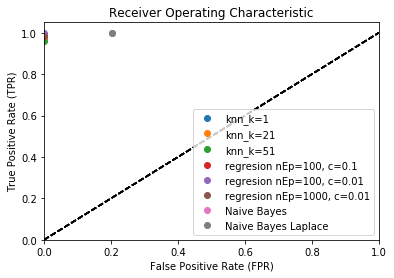

In [212]:
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c1 = Clasificador.ClasificadorVecinosProximos(1, weights='uniform')
error1 = c1.validacionRoc(estrategia, d_ex1_norm, c1, 'knn_k=1', 45)
#c2 = Clasificador.ClasificadorVecinosProximos(3, normalizar=True, weights='distance')
#error2 = c1.validacionRoc(estrategia, d_ex1, c2, 'knn_k=3', 45)
#c3 = Clasificador.ClasificadorVecinosProximos(5, normalizar=True, weights='uniform')
#error3 = c3.validacionRoc(estrategia, d_ex1, c3, 'knn_k=5', 45)
#c4 = Clasificador.ClasificadorVecinosProximos(11, normalizar=True, weights='distance')
#error4 = c4.validacionRoc(estrategia, d_ex1, c4, 'knn_k=11', 45)
c5 = Clasificador.ClasificadorVecinosProximos(21, weights='uniform')
error5 = c5.validacionRoc(estrategia, d_ex1_norm, c5, 'knn_k=21', 45)
c6 = Clasificador.ClasificadorVecinosProximos(51, weights='uniform')
error6 = c6.validacionRoc(estrategia, d_ex1_norm, c6, 'knn_k=51', 45)
#c7 = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=1)
#error7 = c7.validacionRoc(estrategia, d_ex1, c7, 'regresion nEp=100, c=1', 45)
#c8 = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=1)
#error8 = c8.validacionRoc(estrategia, d_ex1, c8, 'regresion nEp=1000, c=1', 45)
c9 = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=0.1)
error9 = c9.validacionRoc(estrategia, d_ex1_norm, c9, 'regresion nEp=100, c=0.1', 45)
#c10 = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=0.1)
#error10 = c10.validacionRoc(estrategia, d_ex1, c10, 'regresion nEp=1000, c=0.1', 45)
c11 = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=0.01)
error11 = c11.validacionRoc(estrategia, d_ex1, c11, 'regresion nEp=100, c=0.01', 45)
c12 = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=0.01)
error12 = c12.validacionRoc(estrategia, d_ex1_norm, c12, 'regresion nEp=1000, c=0.01', 45)
c13 = Clasificador.ClasificadorNaiveBayes()
error13 = c13.validacionRoc(estrategia, d_ex1_norm, c13, 'Naive Bayes', 45)
c14 = Clasificador.ClasificadorNaiveBayes(correccionLaplace=True)
error14 = c14.validacionRoc(estrategia, d_ex1_norm, c14, 'Naive Bayes Laplace', 45)
plt.show()

Como consideración antes de comenzar con el análisis ROC, comentar que hemos
decidido tomar para validación cruzada la mejor de las clasificaciones entre todas las
particiones, para no llenar la curva ROC de diferentes puntos para un mismo clasificador.

En wdbc como podemos apreciar, tomando las mejores combinaciones (una k pequeña y
una k grande para KNN con los datos normalizados), una regresión con constante de
0.01 y 0.1 y sumado a NB con y sin Laplace. Nos damos cuenta de que, como era de
esperar, KNN es el que mejor clasifica, pues es uno de los clasificadores más versátiles,
pero tiene el añadido de ser bastante lento ya que tiene que hacer muchas
comprobaciones con todos los elementos. Gracias a esto consigue una buena precisión.

Por otra parte, nuestra regresión también es capaz de obtener unos resultados bastante
buenos, estando muy cerca de la esquina superior izquierda, resultando llamativo que
con un número de épocas de 100 y una constante de aprendizaje de 0.1 le sea más que
suficiente para colocarse en el y =1.0 x =0.0, frente a un número de épocas de 0.01, y
esto es principalmente debido al overfitting, ya que si tenemos muchas épocas, en
exceso, al llegar nuevos elementos para clasificar, estará la recta tan perfilada que ningún
atributo encajará correctamente, quedando mal clasificado. 

En caso de tener una constante de aprendizaje 0.01 con nEpocas=100 también clasificaría correctamente, en
su punto óptimo, ya que lo único que denota la constante de aprendizaje es la velocidad
con la que varía la recta, aunque en este datase hemos visto que con 100 épocas y una
constante de 0.1 es más que suficiente. Quizás se podría mejorar el clasificador Naive Bayes si 
tras observar los datos, nos damos cuenta de alguna correlación entre los atributos y por lo tanto, creando
un modelo gráfico podríamos mejorar el error de clasificación.

Por último, nuestro NB de la práctica anterior obtiene unos resultados considerablemente
buenos, quedando muy cercano con y sin Laplace (por ello se solapan), aunque lejos del resto de
clasificadores. Esto suponemos que es debido a que el dataset no se adapta
correctamente a ese clasificador, posiblemente motivado por la no independencia de los
atributos, por la que tanto se caracteriza NB.

#### 4.2. ROC en wdbc.data Datos sin normalizar

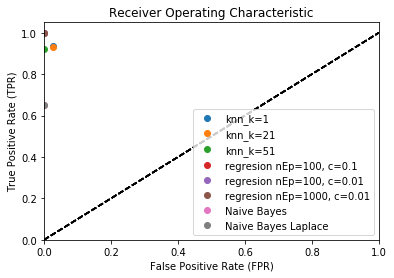

In [213]:
estrategia = EstrategiaParticionado.ValidacionCruzada(5)
c1 = Clasificador.ClasificadorVecinosProximos(1, weights='uniform')
error1 = c1.validacionRoc(estrategia, d_ex1, c1, 'knn_k=1', 45)
#c2 = Clasificador.ClasificadorVecinosProximos(3, normalizar=True, weights='distance')
#error2 = c1.validacionRoc(estrategia, d_ex1, c2, 'knn_k=3', 45)
#c3 = Clasificador.ClasificadorVecinosProximos(5, normalizar=True, weights='uniform')
#error3 = c3.validacionRoc(estrategia, d_ex1, c3, 'knn_k=5', 45)
#c4 = Clasificador.ClasificadorVecinosProximos(11, normalizar=True, weights='distance')
#error4 = c4.validacionRoc(estrategia, d_ex1, c4, 'knn_k=11', 45)
c5 = Clasificador.ClasificadorVecinosProximos(21, weights='uniform')
error5 = c5.validacionRoc(estrategia, d_ex1, c5, 'knn_k=21', 45)
c6 = Clasificador.ClasificadorVecinosProximos(51, weights='uniform')
error6 = c6.validacionRoc(estrategia, d_ex1, c6, 'knn_k=51', 45)
#c7 = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=1)
#error7 = c7.validacionRoc(estrategia, d_ex1, c7, 'regresion nEp=100, c=1', 45)
#c8 = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=1)
#error8 = c8.validacionRoc(estrategia, d_ex1, c8, 'regresion nEp=1000, c=1', 45)
c9 = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=0.1)
error9 = c9.validacionRoc(estrategia, d_ex1, c9, 'regresion nEp=100, c=0.1', 45)
#c10 = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=0.1)
#error10 = c10.validacionRoc(estrategia, d_ex1, c10, 'regresion nEp=1000, c=0.1', 45)
c11 = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=0.01)
error11 = c11.validacionRoc(estrategia, d_ex1, c11, 'regresion nEp=100, c=0.01', 45)
c12 = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=0.01)
error12 = c12.validacionRoc(estrategia, d_ex1, c12, 'regresion nEp=1000, c=0.01', 45)
c13 = Clasificador.ClasificadorNaiveBayes()
error13 = c13.validacionRoc(estrategia, d_ex1, c13, 'Naive Bayes', 45)
c14 = Clasificador.ClasificadorNaiveBayes(correccionLaplace=True)
error14 = c14.validacionRoc(estrategia, d_ex1, c14, 'Naive Bayes Laplace', 45)
plt.show()

Como podemos ver, si no normalizamos los datos los errores cambian ligeramente (los clasificadores ajustan ligeramente peor, ya que no están pegados a la linea vertical), y es llamativo el caso de Naive Bayes que se pega a la linea vertical, arrojando una tasa de erorr nula, pero una tasa de aciertos más baja que si lo normalizamos. Por ello, pese a tener tasa de error con NB normalizando, preferimos que su tasa de aciertos sea mayor también, para representar en su clasificación una cantidad de datos mayor. 

#### 4.3. ROC en online_shoppers.data datos normalizados

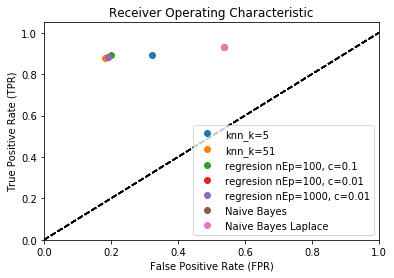

In [214]:
estrategia = EstrategiaParticionado.ValidacionSimple(0.6)
"""
#c1 = Clasificador.ClasificadorVecinosProximos(1, normalizar=True, weights='uniform')
#error1 = c1.validacionRoc(estrategia, d_ex2, c1, 'knn_k=1', 45)
#c2 = Clasificador.ClasificadorVecinosProximos(3, normalizar=True, weights='distance')
#error2 = c1.validacionRoc(estrategia, d_ex1, c2, 'knn_k=3', 45)
"""
c3 = Clasificador.ClasificadorVecinosProximos(5, weights='uniform')
error3 = c3.validacionRoc(estrategia, d_ex2_norm, c3, 'knn_k=5', 45)
#c4 = Clasificador.ClasificadorVecinosProximos(11, normalizar=True, weights='distance')
#error4 = c4.validacionRoc(estrategia, d_ex1, c4, 'knn_k=11', 45)
#c5 = Clasificador.ClasificadorVecinosProximos(21, normalizar=True, weights='uniform')
#error5 = c5.validacionRoc(estrategia, d_ex2, c5, 'knn_k=21', 45)
c6 = Clasificador.ClasificadorVecinosProximos(51, weights='uniform')
error6 = c6.validacionRoc(estrategia, d_ex2_norm, c6, 'knn_k=51', 45)
#c7 = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=1)
#error7 = c7.validacionRoc(estrategia, d_ex1, c7, 'regresion nEp=100, c=1', 45)
#c8 = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=1)
#error8 = c8.validacionRoc(estrategia, d_ex1, c8, 'regresion nEp=1000, c=1', 45)

c9 = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=0.1)
error9 = c9.validacionRoc(estrategia, d_ex2_norm, c9, 'regresion nEp=100, c=0.1', seed=45, oneHot=True)
#c10 = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=0.1)
#error10 = c10.validacionRoc(estrategia, d_ex1, c10, 'regresion nEp=1000, c=0.1', 45)
c11 = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=0.01)
error11 = c11.validacionRoc(estrategia, d_ex2_norm, c11, 'regresion nEp=100, c=0.01', 45)
c12 = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=0.01)
error12 = c12.validacionRoc(estrategia, d_ex2_norm, c12, 'regresion nEp=1000, c=0.01', seed=45, oneHot=True)

c13 = Clasificador.ClasificadorNaiveBayes()
error13 = c13.validacionRoc(estrategia, d_ex2_norm, c13, 'Naive Bayes', seed=45, oneHot=True)
c14 = Clasificador.ClasificadorNaiveBayes(correccionLaplace=True)
error14 = c14.validacionRoc(estrategia, d_ex2_norm, c14, 'Naive Bayes Laplace', seed=45, oneHot=True)
plt.show()

De nuevo hemos clasificado con los mismos parámetros que anteriormente, cogiendo 2 muestras por cada clasificador, entre las que hemos considerado mejores.

Vemos que de nuevo KNN vuelve a gobernar, debido a como comentábamos que es el que mejores resultados obtiene aun coste elevado. Esto también sumado a todas las incorporaciones (clasificación atributo month, distancias, etc…) permiten volver hacer de él un clasificador con una muy alta precisión. Vemos que KNN ajusta mejor con una K relativamente grande, entre 21 y 51, y con una K=5 no clasifica del todo bien, debido al posible ruido que pueda haber entre los vecinos cercanos. 

Por otra parte, en regresión realizamos los ajustes oportunos para que pueda clasificar valores no continuos, viendo que debido a que este es un dataset mucho mayor que el anterior, aunque no por ello de un tamaño desproporcionado(más de 12mil entradas), para regresión necesitamos un número de épocas algo mayor para conseguir afinarlo de modo que clasifique la mayoría los puntos correctamente. 

Es por ello que apreciamos una ligera mejoría entre 0.01 y 0.1. Vemos también que regresión es algo peor para clasificar este dataset, aunque muy a la par de KNN. Esto esta posiblemente motivado debido a que sus datos no son fáciles de separar linealmente, y por ello pierde precisión frente a KNN. 
Esta similitud entre KNN y regresión logística puede venir motivada por la distribución de los puntos del dataset, notamos por ello que obtenemos un error relativamente bueno en regresión, lo que puede indicar una distribución homogénea entre los atributos.

Por último, NB no vuelve a reinar en el podio de las clasificaciones debido a su interpretación de independencia, no encajando completamente con la distribución de los datos de online_shoppers. Quizás podría solucionarse mediante un modelo gráfico de Naive Bayes. 

#### 4.4. ROC en online_shoppers.data datos sin normalizar

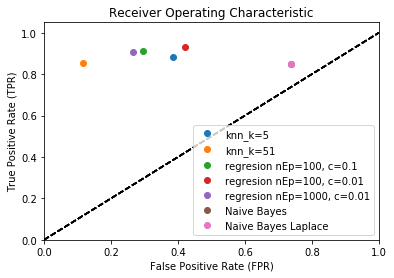

In [215]:
estrategia = EstrategiaParticionado.ValidacionSimple(0.6)
"""
#c1 = Clasificador.ClasificadorVecinosProximos(1, normalizar=True, weights='uniform')
#error1 = c1.validacionRoc(estrategia, d_ex2, c1, 'knn_k=1', 45)
#c2 = Clasificador.ClasificadorVecinosProximos(3, normalizar=True, weights='distance')
#error2 = c1.validacionRoc(estrategia, d_ex1, c2, 'knn_k=3', 45)
"""
c3 = Clasificador.ClasificadorVecinosProximos(5, weights='uniform')
error3 = c3.validacionRoc(estrategia, d_ex2, c3, 'knn_k=5', 45)
#c4 = Clasificador.ClasificadorVecinosProximos(11, normalizar=True, weights='distance')
#error4 = c4.validacionRoc(estrategia, d_ex1, c4, 'knn_k=11', 45)
#c5 = Clasificador.ClasificadorVecinosProximos(21, normalizar=True, weights='uniform')
#error5 = c5.validacionRoc(estrategia, d_ex2, c5, 'knn_k=21', 45)
c6 = Clasificador.ClasificadorVecinosProximos(51, weights='uniform')
error6 = c6.validacionRoc(estrategia, d_ex2, c6, 'knn_k=51', 45)
#c7 = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=1)
#error7 = c7.validacionRoc(estrategia, d_ex1, c7, 'regresion nEp=100, c=1', 45)
#c8 = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=1)
#error8 = c8.validacionRoc(estrategia, d_ex1, c8, 'regresion nEp=1000, c=1', 45)

c9 = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=0.1)
error9 = c9.validacionRoc(estrategia, d_ex2, c9, 'regresion nEp=100, c=0.1', seed=45, oneHot=True)
#c10 = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=0.1)
#error10 = c10.validacionRoc(estrategia, d_ex1, c10, 'regresion nEp=1000, c=0.1', 45)
c11 = Clasificador.ClasificadorRegresionLogistica(nEpocas=100, constante=0.01)
error11 = c11.validacionRoc(estrategia, d_ex2, c11, 'regresion nEp=100, c=0.01', 45)
c12 = Clasificador.ClasificadorRegresionLogistica(nEpocas=1000, constante=0.01)
error12 = c12.validacionRoc(estrategia, d_ex2, c12, 'regresion nEp=1000, c=0.01', seed=45, oneHot=True)

c13 = Clasificador.ClasificadorNaiveBayes()
error13 = c13.validacionRoc(estrategia, d_ex2, c13, 'Naive Bayes', seed=45, oneHot=True)
c14 = Clasificador.ClasificadorNaiveBayes(correccionLaplace=True)
error14 = c14.validacionRoc(estrategia, d_ex2, c14, 'Naive Bayes Laplace', seed=45, oneHot=True)
plt.show()

Como podemos ver de nuevo, sin normalizar los datos salen más dispersos, y vuelve a ser llamativo el caso de NB que se aleja más de la zona de acierto, acercándose a la diagonal. 
En los clasificadores se comienzan a ver mayores diferencias, pese a que la normalización en este dataset era prácticamente irrelevante debido a la homogenéidad de los datos. Esto puede ser debido a pequeñas imprecisiones, o a una partición escogida incorrecta, puesto que tras hacer diversas pruebas a veces salían todos juntos y otras más dispersos. No podemos establecer una correlacción clara en este caso. 